#Face detection

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/face-mask-detection")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'face-mask-detection' dataset.
Path to dataset files: /kaggle/input/face-mask-detection


In [2]:
pip install opendatasets scikit-learn pyyaml pandas

In [3]:
import os
import shutil
import glob
import random
import xml.etree.ElementTree as ET
import yaml
from sklearn.model_selection import train_test_split
import opendatasets as od # Ensure this is imported for the download function

# --- Configuration ---
DATASET_URL = 'https://www.kaggle.com/datasets/andrewmvd/face-mask-detection'
OUTPUT_DIR = 'datasets/face_mask_yolo_clean'

# We ONLY define the classes you want.
# Any class in the XML not in this list is automatically ignored.
CLASSES = ["with_mask", "without_mask"]

def download_dataset():
    """Downloads dataset using opendatasets library."""
    if os.path.exists('face-mask-detection'):
        print("Dataset folder found. Skipping download.")
        return

    print(f"Downloading dataset from {DATASET_URL}...")
    try:
        od.download(DATASET_URL, data_dir='.')
    except Exception as e:
        print(f"Error downloading: {e}")
        print("Please ensure you have your kaggle.json file or credentials ready.")
        exit()

def convert_box(size, box):
    """Converts (xmin, ymin, xmax, ymax) to YOLO (x_center, y_center, width, height)."""
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (box[0] + box[1]) / 2.0
    y = (box[2] + box[3]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    return (x * dw, y * dh, w * dw, h * dh)

def convert_xml_to_txt(xml_path, output_path):
    """Parses XML and writes YOLO format .txt file, filtering unwanted classes."""
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        size = root.find('size')
        w = int(size.find('width').text)
        h = int(size.find('height').text)

        yolo_lines = []

        for obj in root.iter('object'):
            cls = obj.find('name').text

            # --- FILTERING LOGIC ---
            # If the class found in XML is not in our desired CLASSES list, skip it.
            if cls not in CLASSES:
                continue

            cls_id = CLASSES.index(cls)

            xmlbox = obj.find('bndbox')
            b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text),
                 float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))

            bb = convert_box((w, h), b)
            yolo_lines.append(f"{cls_id} {bb[0]:.6f} {bb[1]:.6f} {bb[2]:.6f} {bb[3]:.6f}")

        # Only create the file if we found valid classes (with_mask or without_mask)
        if yolo_lines:
            with open(output_path, 'w') as f:
                f.write('\n'.join(yolo_lines))
            return True # Success: Image contains relevant data
        else:
            return False # Fail: Image only contained "incorrect" masks or nothing

    except Exception as e:
        print(f"Warning: Issue parsing {xml_path}: {e}")
        return False

def prepare_structure():
    """Creates the YOLO directory structure."""
    dirs = [
        f'{OUTPUT_DIR}/images/train',
        f'{OUTPUT_DIR}/images/val',
        f'{OUTPUT_DIR}/labels/train',
        f'{OUTPUT_DIR}/labels/val'
    ]
    for d in dirs:
        os.makedirs(d, exist_ok=True)
    # Clear existing data.yaml if it exists to avoid confusion
    if os.path.exists(f'{OUTPUT_DIR}/data.yaml'):
        os.remove(f'{OUTPUT_DIR}/data.yaml')

def process_data():
    # 1. Download
    download_dataset()

    # 2. Setup Directories
    prepare_structure()

    # 3. Get all images
    source_img_dir = 'face-mask-detection/images'
    source_xml_dir = 'face-mask-detection/annotations'

    images = glob.glob(os.path.join(source_img_dir, '*.png'))
    if not images:
        print("No images found! Check if the dataset downloaded correctly.")
        return

    print(f"Found {len(images)} total source images.")

    # 4. Split Train/Val
    train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

    def process_batch(image_list, split_type):
        count = 0
        for img_path in image_list:
            filename = os.path.basename(img_path)
            xml_filename = filename.replace('.png', '.xml')
            xml_path = os.path.join(source_xml_dir, xml_filename)

            target_img_path = f'{OUTPUT_DIR}/images/{split_type}/{filename}'
            target_label_path = f'{OUTPUT_DIR}/labels/{split_type}/{filename.replace(".png", ".txt")}'

            if os.path.exists(xml_path):
                # Only copy image if convert_xml_to_txt returns True (meaning it has valid labels)
                has_valid_labels = convert_xml_to_txt(xml_path, target_label_path)
                if has_valid_labels:
                    shutil.copy(img_path, target_img_path)
                    count += 1
        return count

    print("Processing Training Set...")
    train_count = process_batch(train_imgs, 'train')
    print("Processing Validation Set...")
    val_count = process_batch(val_imgs, 'val')

    print(f"Done! Included {train_count + val_count} images (excluded images with only 'incorrect' masks).")

def create_yaml():
    """Generates the data.yaml file."""
    yaml_content = {
        'path': os.path.abspath(OUTPUT_DIR),
        'train': 'images/train',
        'val': 'images/val',
        'nc': len(CLASSES),
        'names': CLASSES
    }

    yaml_path = f'{OUTPUT_DIR}/data.yaml'
    with open(yaml_path, 'w') as f:
        yaml.dump(yaml_content, f, sort_keys=False)
    print(f"Generated config file at: {yaml_path}")

if __name__ == "__main__":
    process_data()
    create_yaml()
    print("\nREADY TO TRAIN!")
    print(f"Config file: {os.path.abspath(OUTPUT_DIR)}/data.yaml")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: AlexandruSauca
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/face-mask-detection


100%|██████████| 398M/398M [00:00<00:00, 1.67GB/s]



Found 853 total source images.
Processing Training Set...
Processing Validation Set...
Done! Included 832 images (excluded images with only 'incorrect' masks).
Generated config file at: datasets/face_mask_yolo_clean/data.yaml

READY TO TRAIN!
Config file: /content/datasets/face_mask_yolo_clean/data.yaml


In [4]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 45.6 MB/s eta 0:00:00


In [6]:
!yolo task=detect mode=train model=yolov8n.pt data='/content/datasets/face_mask_yolo_clean/data.yaml' epochs=200 imgsz=640 hsv_v=0.4 hsv_s=0.7 scale=0.8 degrees=15.0 mosaic=0.5 mixup=0.1

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/face_mask_yolo_clean/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgs

In [8]:
from ultralytics import YOLO

model = YOLO("/content/runs/detect/train/weights/best.pt")
model_onnx = model.export(format='onnx')

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '/content/runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<=1.19.1', 'onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 14 packages in 139ms
Prepared 6 packages in 3.55s
Installed 6 packages in 263ms
 + colorama==0.4.6
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnx==1.19.1
 + onnxruntime-gpu==1.23.2
 + onnxslim==0.1.78

requirements: AutoUpdate success ✅ 4.6s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting 

In [5]:
!unzip /content/drive/MyDrive/dataset.zip

Archive:  /content/drive/MyDrive/dataset.zip
   creating: dataset/
   creating: dataset/db/
   creating: dataset/db/indoor_persons/
  inflating: dataset/db/indoor_persons/Andres - Indoor.jpg  
  inflating: dataset/db/indoor_persons/Cristina - Indoor.jpg  
  inflating: dataset/db/indoor_persons/DaniB - Indoor.jpg  
  inflating: dataset/db/indoor_persons/DaniF - Indoor.jpg  
  inflating: dataset/db/indoor_persons/Diego - Indoor.jpg  
  inflating: dataset/db/indoor_persons/Ester - Indoor.jpg  
  inflating: dataset/db/indoor_persons/Isa - Indoor.jpg  
  inflating: dataset/db/indoor_persons/Marcos - Indoor.jpg  
  inflating: dataset/db/indoor_persons/Narciso - Indoor.jpg  
  inflating: dataset/db/indoor_persons/Pablo - Indoor.jpg  
   creating: dataset/db/outdoor_persons/
  inflating: dataset/db/outdoor_persons/Andres - Outdoor.jpg  
  inflating: dataset/db/outdoor_persons/Cristina - Outdoor.jpg  
  inflating: dataset/db/outdoor_persons/DaniB - Outdoor.jpg  
  inflating: dataset/db/outdoor_

In [1]:
import os
import glob
from ultralytics import YOLO
from IPython.display import Image, display
import random

# --- CONFIGURATION ---
# The root folder containing 'Indoor', 'Outdoor', etc.
TEST_ROOT_PATH = '/content/dataset/test'
MODEL_PATH = '/content/runs/detect/train/weights/best.pt'

# Extensions to look for
EXTENSIONS = ['*.jpg', '*.jpeg', '*.png', '*.bmp']

def test_recursive():
    # 1. Check Model
    if not os.path.exists(MODEL_PATH):
        print(f"Error: Model not found at {MODEL_PATH}")
        return

    # 2. Find ALL images recursively (Indoor, Outdoor, masked, etc.)
    image_paths = []
    for ext in EXTENSIONS:
        # ** matches any subfolder level
        found = glob.glob(os.path.join(TEST_ROOT_PATH, '**', ext), recursive=True)
        image_paths.extend(found)

    if not image_paths:
        print(f"No images found in {TEST_ROOT_PATH}. Check your path or file extensions.")
        return

    print(f"Found {len(image_paths)} images in subfolders.")
    print(f"Loading model from {MODEL_PATH}...")
    model = YOLO(MODEL_PATH)

    # 3. Run Inference on the list of images
    # We pass the list 'image_paths' directly to source
    print("Running inference...")
    results = model.predict(source=image_paths, save=True, conf=0.5, save_txt=False, stream=False)

    print("\n" + "="*40)
    print("TESTING COMPLETE")
    print("="*40)

    # 4. Locate Results
    # Find the latest prediction folder
    predict_dirs = glob.glob('/content/runs/detect/predict*')
    latest_dir = max(predict_dirs, key=os.path.getmtime)
    print(f"All detection results saved to: {latest_dir}")

    # 5. Display 3 Random Samples
    print("\nDisplaying random results:")
    result_images = glob.glob(os.path.join(latest_dir, '*'))

    # Pick 3 random images to show diversity
    if len(result_images) > 0:
        samples = random.sample(result_images, min(3, len(result_images)))
        for img_path in samples:
            display(Image(filename=img_path, width=400))
            print(f"Shown: {os.path.basename(img_path)}")

if __name__ == "__main__":
    test_recursive()

Found 405 images in subfolders.
Loading model from /content/runs/detect/train/weights/best.onnx...
Running inference...
Loading /content/runs/detect/train/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime 1.23.2 ('CUDAExecutionProvider', {'device_id': 0})



RuntimeError: Error in execution: Got invalid dimensions for input: images for the following indices
 index: 0 Got: 405 Expected: 1
 Please fix either the inputs/outputs or the model.

In [2]:
import os
import glob
from ultralytics import YOLO
from IPython.display import Image, display
import random

# --- CONFIGURATION ---
TEST_ROOT_PATH = '/content/dataset/test'
# Keep ONNX if you really need it
MODEL_PATH = '/content/runs/detect/train/weights/best.onnx'
EXTENSIONS = ['*.jpg', '*.jpeg', '*.png', '*.bmp']

def test_recursive_onnx():
    if not os.path.exists(MODEL_PATH):
        print(f"Error: Model not found at {MODEL_PATH}")
        return

    # 1. Find images
    image_paths = []
    for ext in EXTENSIONS:
        found = glob.glob(os.path.join(TEST_ROOT_PATH, '**', ext), recursive=True)
        image_paths.extend(found)

    if not image_paths:
        print("No images found.")
        return

    print(f"Found {len(image_paths)} images. Loading ONNX model...")
    model = YOLO(MODEL_PATH)

    print("Running inference (One-by-One for ONNX)...")

    # --- THE FIX FOR ONNX ---
    # We loop through the images and predict one at a time
    for i, img_path in enumerate(image_paths):
        # We process one image at a time to satisfy "Expected: 1"
        # stream=False ensures it finishes before moving on
        model.predict(source=img_path, save=True, conf=0.5, save_txt=False)

        # Optional: Print progress every 10 images
        if i % 10 == 0:
            print(f"Processed {i}/{len(image_paths)}...")

    print("\nTESTING COMPLETE")

    # Display logic remains similar...
    predict_dirs = glob.glob('/content/runs/detect/predict*')
    latest_dir = max(predict_dirs, key=os.path.getmtime)
    print(f"Results saved to: {latest_dir}")

    result_images = glob.glob(os.path.join(latest_dir, '*'))
    if len(result_images) > 0:
        samples = random.sample(result_images, min(3, len(result_images)))
        for img_path in samples:
            display(Image(filename=img_path, width=400))
            print(f"Shown: {os.path.basename(img_path)}")

if __name__ == "__main__":
    test_recursive_onnx()

Output hidden; open in https://colab.research.google.com to view.

In [9]:
pip install sahi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 11.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.12.0.88
    Uninstalling opencv-python-4.12.0.88:
      Successfully uninstalled opencv-python-4.12.0.88


In [2]:
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction

# 1. Load model through SAHI wrapper
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov8',
    model_path='/content/runs/detect/train/weights/best.onnx',
    confidence_threshold=0.35,
    device="cuda"  # or 'cpu'
)

# 2. Run "Sliced" Prediction
result = get_sliced_prediction(
    "/content/dataset/test/Indoor/Non-masked/Andres - Indoor - 21C.png",
    detection_model,
    slice_height=320,
    slice_width=320,
    overlap_height_ratio=0.2, # Overlap ensures faces on the edge of a slice aren't missed
    overlap_width_ratio=0.2
)

result.export_visuals(export_dir="results/")

Performing prediction on 135 slices.


In [3]:
import os
import shutil
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction

# --- CONFIGURATION ---
SOURCE_ROOT = "/content/dataset/test"  # Where your images are
OUTPUT_ROOT = "/content/results"       # Where to save results
MODEL_PATH = "/content/runs/detect/train/weights/best.pt"

# 1. Load Model (Once)
print(f"Loading model from {MODEL_PATH}...")
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov8',
    model_path=MODEL_PATH,
    confidence_threshold=0.5,
    device="cuda"  # Change to 'cpu' if you don't have a GPU
)

# 2. Iterate recursively through all folders
print(f"Processing images from {SOURCE_ROOT}...")

for root, dirs, files in os.walk(SOURCE_ROOT):
    for filename in files:
        # Filter for images only
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.webp')):

            # Construct full file path
            source_path = os.path.join(root, filename)

            # Create corresponding output path (Mirror structure)
            # e.g., /content/dataset/test/Indoor/masked -> /content/results/Indoor/masked
            relative_path = os.path.relpath(root, SOURCE_ROOT)
            target_folder = os.path.join(OUTPUT_ROOT, relative_path)
            os.makedirs(target_folder, exist_ok=True)

            print(f"Predicting: {filename}")

            try:
                # 3. Run "Sliced" Prediction
                result = get_sliced_prediction(
                    source_path,
                    detection_model,
                    slice_height=320,
                    slice_width=320,
                    overlap_height_ratio=0.2,
                    overlap_width_ratio=0.2
                )

                # 4. Export Result
                # export_visuals saves a file named "prediction_visual.png"
                result.export_visuals(export_dir=target_folder, file_name="temp_result")

                # 5. Rename to original filename (so we don't overwrite)
                # SAHI exports as [file_name].png, usually.
                generated_file = os.path.join(target_folder, "temp_result.png")
                final_path = os.path.join(target_folder, filename)

                if os.path.exists(generated_file):
                    # If source was .jpg and sahi saved .png, this handles the extension switch
                    if os.path.exists(final_path):
                        os.remove(final_path) # Overwrite if exists
                    os.rename(generated_file, final_path)

            except Exception as e:
                print(f"Error processing {filename}: {e}")

print("\n" + "="*40)
print(f"Done! Results saved to: {OUTPUT_ROOT}")
print("="*40)

Loading model from /content/runs/detect/train/weights/best.onnx...
Loading /content/runs/detect/train/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime 1.23.2 ('CUDAExecutionProvider', {'device_id': 0})
Loading /content/runs/detect/train/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime 1.23.2 ('CUDAExecutionProvider', {'device_id': 0})
Loading /content/runs/detect/train/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime 1.23.2 ('CUDAExecutionProvider', {'device_id': 0})
Processing images from /content/dataset/test...
Predicting: Andres - Outdoor - 24C.png
Performing prediction on 135 slices.
Loading /content/runs/detect/train/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime 1.23.2 ('CUDAExecutionProvider', {'device_id': 0})
Predicting: Pablo - Outdoor - 6C.png
Performing prediction on 135 slices.
Predicting: Cristina - Outdoor - 12C.png
Performing prediction on 135 slices.
Predicting: Narciso - Outdoor - 6C.png
Perfor

KeyboardInterrupt: 

In [5]:
import os
import shutil
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction

# --- CONFIGURATION ---
SOURCE_ROOT = "/content/dataset/test"  # Input folder
OUTPUT_ROOT = "/content/results"       # Output folder
MODEL_PATH = "/content/runs/detect/train/weights/best.onnx" # Your model

# 1. Load Model
print(f"Loading model from {MODEL_PATH}...")
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov8',
    model_path=MODEL_PATH,
    confidence_threshold=0.5,
    device="cuda" # Change to 'cpu' if needed
)

# 2. Iterate recursively through all folders
print(f"Processing images from {SOURCE_ROOT} (Max 10 per folder)...")

total_count = 0
errors = 0

for root, dirs, files in os.walk(SOURCE_ROOT):
    # Optional: Sort files to ensure we always pick the same "first 10"
    files.sort()

    # --- NEW: Counter for the current subfolder ---
    folder_image_count = 0

    for filename in files:
        # Filter for images
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.webp')):

            # --- NEW: Check limit ---
            if folder_image_count >= 10:
                # We hit the limit for this specific folder.
                # Break the inner loop to move to the NEXT folder in os.walk
                break

            source_path = os.path.join(root, filename)

            # Create corresponding output path (Mirror structure)
            relative_path = os.path.relpath(root, SOURCE_ROOT)
            target_folder = os.path.join(OUTPUT_ROOT, relative_path)
            os.makedirs(target_folder, exist_ok=True)

            # Simple progress print
            print(f"[{total_count+1}] Processing: {filename} ... ", end="")

            try:
                # 3. Run "Sliced" Prediction
                result = get_sliced_prediction(
                    source_path,
                    detection_model,
                    slice_height=320,
                    slice_width=320,
                    overlap_height_ratio=0.2,
                    overlap_width_ratio=0.2
                )

                # 4. Export Result (Saves to disk)
                result.export_visuals(export_dir=target_folder, file_name="temp_result")

                # 5. Rename to original filename
                generated_file = os.path.join(target_folder, "temp_result.png")
                final_path = os.path.join(target_folder, filename)

                if os.path.exists(generated_file):
                    if os.path.exists(final_path):
                        os.remove(final_path)
                    os.rename(generated_file, final_path)
                    print("Saved.")

                    total_count += 1
                    folder_image_count += 1 # Increment folder counter
                else:
                    print("No detection (or save failed).")

            except Exception as e:
                print(f"ERROR: {e}")
                errors += 1

print("\n" + "="*40)
print(f"Done! Processed {total_count} images.")
print(f"Errors encountered: {errors}")
print(f"All results saved to: {OUTPUT_ROOT}")
print("="*40)

Loading model from /content/runs/detect/train/weights/best.onnx...
Loading /content/runs/detect/train/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime 1.23.2 ('CUDAExecutionProvider', {'device_id': 0})
Loading /content/runs/detect/train/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime 1.23.2 ('CUDAExecutionProvider', {'device_id': 0})
Loading /content/runs/detect/train/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime 1.23.2 ('CUDAExecutionProvider', {'device_id': 0})
Processing images from /content/dataset/test (Max 10 per folder)...
[1] Processing: Andres - Outdoor - 12C.png ... Performing prediction on 135 slices.
Loading /content/runs/detect/train/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime 1.23.2 ('CUDAExecutionProvider', {'device_id': 0})
Saved.
[2] Processing: Andres - Outdoor - 15C.png ... Performing prediction on 135 slices.
Saved.
[3] Processing: Andres - Outdoor - 18C.png ... Performing prediction on

In [6]:
!zip -r /content/inference_results.zip /content/results

  adding: content/results/ (stored 0%)
  adding: content/results/Outdoor/ (stored 0%)
  adding: content/results/Outdoor/Non-masked/ (stored 0%)
  adding: content/results/Outdoor/Non-masked/Andres - Outdoor - 24C.png (deflated 3%)
  adding: content/results/Outdoor/Non-masked/Pablo - Outdoor - 6C.png (deflated 4%)
  adding: content/results/Outdoor/Non-masked/Cristina - Outdoor - 12C.png (deflated 4%)
  adding: content/results/Outdoor/Non-masked/Narciso - Outdoor - 6C.png (deflated 4%)
  adding: content/results/Outdoor/Non-masked/Narciso - Outdoor - 12C.png (deflated 5%)
  adding: content/results/Outdoor/Non-masked/DaniF - Outdoor - 24C.png (deflated 6%)
  adding: content/results/Outdoor/Non-masked/Andres - Outdoor - 15C.png (deflated 4%)
  adding: content/results/Outdoor/Non-masked/Isa - Outdoor - 21C.png (deflated 8%)
  adding: content/results/Outdoor/Non-masked/Andres - Outdoor - 9C.png (deflated 4%)
  adding: content/results/Outdoor/Non-masked/Andres - Outdoor - 21C.png (deflated 3%)


In [7]:
!cp -r /content/runs /content/drive/MyDrive/runs_face_detect

In [8]:
!cp -r /content/results /content/drive/MyDrive/results_face_detect

In [10]:
!zip -r /content/runs.zip /content/runs

  adding: content/runs/ (stored 0%)
  adding: content/runs/detect/ (stored 0%)
  adding: content/runs/detect/predict2/ (stored 0%)
  adding: content/runs/detect/train/ (stored 0%)
  adding: content/runs/detect/train/val_batch2_labels.jpg (deflated 7%)
  adding: content/runs/detect/train/train_batch2.jpg (deflated 6%)
  adding: content/runs/detect/train/args.yaml (deflated 53%)
  adding: content/runs/detect/train/confusion_matrix.png (deflated 30%)
  adding: content/runs/detect/train/labels.jpg (deflated 32%)
  adding: content/runs/detect/train/train_batch7980.jpg (deflated 11%)
  adding: content/runs/detect/train/results.csv (deflated 63%)
  adding: content/runs/detect/train/results.png (deflated 8%)
  adding: content/runs/detect/train/val_batch2_pred.jpg (deflated 7%)
  adding: content/runs/detect/train/BoxR_curve.png (deflated 12%)
  adding: content/runs/detect/train/confusion_matrix_normalized.png (deflated 29%)
  adding: content/runs/detect/train/val_batch1_pred.jpg (deflated 8%)
 

#Face recognition

In [9]:
!pip install insightface onnxruntime-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 32.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for insightface: filename=insightface-0.7.3-cp312-cp312-linux_x86_64.whl size=1071350 sha256=f345c3652197a8f53249dcb164c334f13ce03e7b4a1c4e95eeead3e24d102d04
  Stored in directory: /root/.cache/pip/wheels/73/3c/e2/6d4815e8a8b33a2006554d65ce0d1f973e768f4c7a222fa675
Successfully built insightface


In [20]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muhammeddalkran/masked-facerecognition")

print("Path to dataset files:", path)

100%|██████████| 593M/593M [00:29<00:00, 21.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4


In [25]:
import os

root = "/root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4"

for path, dirs, files in os.walk(root):
    print("PATH:", path)
    print("DIRS:", dirs)
    print("FILES:", files)
    print("-"*80)
    # Don't break; let it print FULL structure


PATH: /root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4
DIRS: ['AFDB_masked_face_dataset', 'AFDB_face_dataset']
FILES: []
--------------------------------------------------------------------------------
PATH: /root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4/AFDB_masked_face_dataset
DIRS: ['AFDB_masked_face_dataset']
FILES: []
--------------------------------------------------------------------------------
PATH: /root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4/AFDB_masked_face_dataset/AFDB_masked_face_dataset
DIRS: ['zhangrui', 'qinlan', 'handongjun', 'xiongdailin', 'liyitong', 'cengyongti', 'tanjing', 'qiaorenliang', 'lanxi', 'zhangziyi', 'gongbeibi', 'yumenglong', 'zhengyuanchang', 'maolinlin', 'huangjinglun', 'zhanghuiwen', 'yeqianwen', 'zhangbichen', 'zhangzhehan', 'huge', 'huashao', 'wuzhenyu', 'jujingyi', 'songqian', 'huangxuan', 'wangqing', 'huangshengyi', 'xieanqi', 'caoying', 'zhuy

In [26]:
import os

root = "/root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4"

print("UNMASKED SUBFOLDERS:")
print(os.listdir(os.path.join(root, "AFDB_face_dataset")))


UNMASKED SUBFOLDERS:
['AFDB_face_dataset']


In [28]:
from insightface.app import FaceAnalysis
import torch

app = FaceAnalysis(name='buffalo_l')
app.prepare(ctx_id=0, det_size=(640, 640))

# Access ArcFace-like feature extractor
backbone = app.models['recognition']


download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:02<00:00, 111758.44KB/s]


Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with o

In [45]:
import os
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import numpy as np

# --- 1. EARLY STOPPING CLASS (Prevents Overfitting) ---
class EarlyStopping:
    """
    Stops training if validation loss doesn't improve after a given patience.
    Saves the best model automatically.
    """
    def __init__(self, patience=5, delta=0, path='best_arcface_model.pth'):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model, head):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, head)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'   ⚠️ EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, head)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, head):
        print(f'   ✅ Validation loss improved. Saving best model to {self.path}...')
        torch.save({
            'backbone': model.state_dict(),
            'head': head.state_dict()
        }, self.path)

# --- 2. DATASET LOADER (With Augmentation) ---
class AFDBMaskedDataset(Dataset):
    def __init__(self, root_dir, img_size=112):
        self.samples = []
        self.img_size = img_size

        # --- AUGMENTATION ADDED HERE ---
        # Random flipping and lighting changes force the model to generalize
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

        # Handle Paths
        masked_root = os.path.join(root_dir, "AFDB_masked_face_dataset/AFDB_masked_face_dataset")
        unmasked_root = os.path.join(root_dir, "AFDB_face_dataset/AFDB_face_dataset")

        # Fallback check
        if not os.path.exists(unmasked_root):
            unmasked_root = os.path.join(root_dir, "AFDB_face_dataset")
            masked_root = os.path.join(root_dir, "AFDB_masked_face_dataset")

        print(f"Scanning {unmasked_root}...")

        if os.path.exists(unmasked_root):
            identities = sorted(os.listdir(unmasked_root))
        else:
            print("Error: Dataset path not found.")
            identities = []

        for identity in identities:
            id_unmasked = os.path.join(unmasked_root, identity)
            id_masked = os.path.join(masked_root, identity)

            # Add unmasked images
            if os.path.isdir(id_unmasked):
                for img_path in glob.glob(os.path.join(id_unmasked, "*.jpg")):
                    self.samples.append((img_path, identity))

            # Add masked images
            if os.path.isdir(id_masked):
                for img_path in glob.glob(os.path.join(id_masked, "*.jpg")):
                    self.samples.append((img_path, identity))

        # Create numeric labels
        ids = sorted(list(set([s[1] for s in self.samples])))
        self.id2label = {id_name: idx for idx, id_name in enumerate(ids)}

        print(f"Total images: {len(self.samples)}")
        print(f"Total identities: {len(self.id2label)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, identity = self.samples[idx]
        try:
            img = Image.open(img_path).convert("RGB")
            img = self.transform(img)
            label = self.id2label[identity]
            return img, label
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            return torch.zeros((3, self.img_size, self.img_size)), 0

# --- 3. ARCFACE LOSS ---
class ArcFaceLoss(nn.Module):
    def __init__(self, embedding_size, num_classes, s=30.0, m=0.30): # Lower m to 0.3 for faster learning
        super().__init__()
        self.in_features = embedding_size
        self.out_features = num_classes
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, embedding_size))
        nn.init.xavier_uniform_(self.weight)

        self.cos_m = np.cos(m)
        self.sin_m = np.sin(m)
        self.th = np.cos(np.pi - m)
        self.mm = np.sin(np.pi - m) * m

    def forward(self, embedding, labels):
        cosine = F.linear(F.normalize(embedding), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        one_hot = torch.zeros(cosine.size(), device=embedding.device)
        one_hot.scatter_(1, labels.view(-1, 1).long(), 1)

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

# --- 4. BACKBONE MODEL ---
class FaceRecognitionModel(nn.Module):
    def __init__(self):
        super(FaceRecognitionModel, self).__init__()
        # Use updated weights parameter to avoid warnings
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.backbone.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512)
        )

    def forward(self, x):
        return self.backbone(x)

# --- 5. ROBUST TRAINING LOOP ---
def train_robust(root_dir, batch_size=64, epochs=30, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # A. PREPARE DATA (WITH SPLIT)
    full_dataset = AFDBMaskedDataset(root_dir)
    if len(full_dataset) == 0: return

    # 80% Train, 20% Validation
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    num_classes = len(full_dataset.id2label)
    print(f"\n--- Data Split ---")
    print(f"Training on: {len(train_dataset)} images")
    print(f"Validating on: {len(val_dataset)} images")
    print(f"Identities: {num_classes}")

    # B. MODEL SETUP
    model = FaceRecognitionModel().to(device)
    arcface_loss = ArcFaceLoss(embedding_size=512, num_classes=num_classes).to(device)

    # C. OPTIMIZER & STOPPING
    optimizer = torch.optim.SGD([
        {'params': model.parameters(), 'lr': lr * 0.1},
        {'params': arcface_loss.parameters(), 'lr': lr}
    ], momentum=0.9, weight_decay=5e-4)

    criterion = nn.CrossEntropyLoss()
    early_stopping = EarlyStopping(patience=5, path='best_arcface_model.pth')

    print("\n--- Starting Training ---")

    for epoch in range(epochs):
        # 1. TRAIN
        model.train()
        arcface_loss.train()
        train_loss = 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            embeddings = model(imgs)
            logits = arcface_loss(embeddings, labels)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # 2. VALIDATE (No Gradient)
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)

                embeddings = model(imgs)
                # Validation metric uses ArcFace loss to be consistent
                logits = arcface_loss(embeddings, labels)
                loss = criterion(logits, labels)
                val_loss += loss.item()

                _, predicted = torch.max(logits.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        # 3. CHECK EARLY STOPPING
        early_stopping(avg_val_loss, model, arcface_loss)

        if early_stopping.early_stop:
            print("\n🛑 Early stopping triggered. Training stopped to prevent overfitting.")
            break

    print("\nTraining Finished. Best model is saved as 'best_arcface_model.pth'")

if __name__ == "__main__":
    # Ensure this path matches your Kaggle download location
    DATA_PATH = "/root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4"
    train_robust(DATA_PATH)

Using device: cuda
Scanning /root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4/AFDB_face_dataset/AFDB_face_dataset...
Total images: 91806
Total identities: 460

--- Data Split ---
Training on: 73444 images
Validating on: 18362 images
Identities: 460
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 159MB/s]



--- Starting Training ---
Epoch 1/30 | Train Loss: 15.3656 | Val Loss: 14.9094 | Val Acc: 0.00%
   ✅ Validation loss improved. Saving best model to best_arcface_model.pth...
Epoch 2/30 | Train Loss: 14.3887 | Val Loss: 14.1435 | Val Acc: 0.00%
   ✅ Validation loss improved. Saving best model to best_arcface_model.pth...
Epoch 3/30 | Train Loss: 13.7459 | Val Loss: 13.6426 | Val Acc: 0.00%
   ✅ Validation loss improved. Saving best model to best_arcface_model.pth...
Epoch 4/30 | Train Loss: 13.2205 | Val Loss: 13.2073 | Val Acc: 0.02%
   ✅ Validation loss improved. Saving best model to best_arcface_model.pth...
Epoch 5/30 | Train Loss: 12.7080 | Val Loss: 12.7665 | Val Acc: 0.04%
   ✅ Validation loss improved. Saving best model to best_arcface_model.pth...
Epoch 6/30 | Train Loss: 12.1927 | Val Loss: 12.3191 | Val Acc: 0.11%
   ✅ Validation loss improved. Saving best model to best_arcface_model.pth...
Epoch 7/30 | Train Loss: 11.6688 | Val Loss: 11.8552 | Val Acc: 0.20%
   ✅ Validation

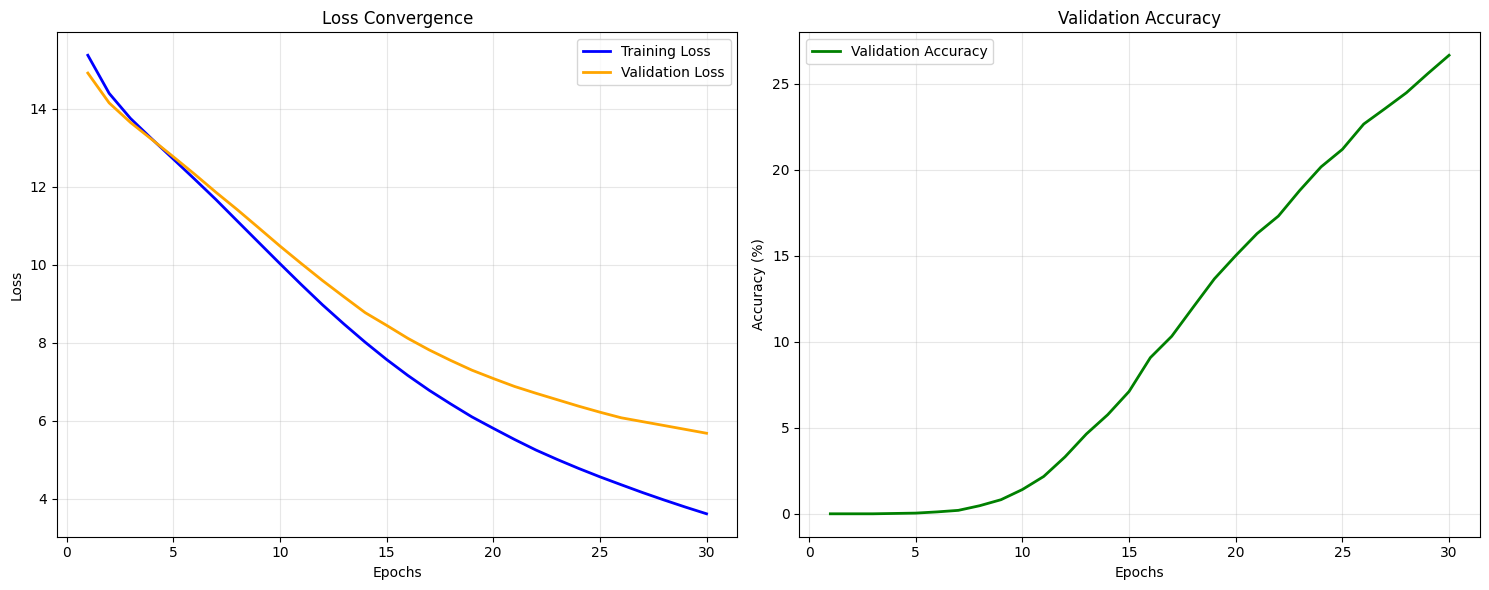

In [149]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. EXTRACTED DATA (From your logs) ---
epochs = list(range(1, 31))

train_loss = [
    15.3656, 14.3887, 13.7459, 13.2205, 12.7080, 12.1927, 11.6688, 11.1197, 10.5724, 10.0266,
    9.4897, 8.9681, 8.4784, 8.0096, 7.5686, 7.1577, 6.7778, 6.4305, 6.0971, 5.8043,
    5.5177, 5.2473, 5.0051, 4.7763, 4.5602, 4.3569, 4.1569, 3.9677, 3.7859, 3.6124
]

val_loss = [
    14.9094, 14.1435, 13.6426, 13.2073, 12.7665, 12.3191, 11.8552, 11.4097, 10.9453, 10.4774,
    10.0286, 9.5905, 9.1759, 8.7679, 8.4440, 8.1100, 7.8127, 7.5453, 7.2944, 7.0808,
    6.8765, 6.7024, 6.5372, 6.3717, 6.2173, 6.0734, 5.9746, 5.8758, 5.7765, 5.6770
]

val_acc = [
    0.00, 0.00, 0.00, 0.02, 0.04, 0.11, 0.20, 0.47, 0.82, 1.41,
    2.17, 3.31, 4.64, 5.76, 7.11, 9.08, 10.32, 12.00, 13.66, 15.01,
    16.29, 17.31, 18.80, 20.17, 21.19, 22.66, 23.56, 24.48, 25.59, 26.66
]

# --- 2. PLOTTING ---
plt.figure(figsize=(15, 6))

# Subplot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss', color='blue', linewidth=2)
plt.plot(epochs, val_loss, label='Validation Loss', color='orange', linewidth=2)
plt.title('Loss Convergence')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_acc, label='Validation Accuracy', color='green', linewidth=2)
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("training_progress.png")
plt.show()

Loading Dataset...
Loading Model from /content/best_arcface_model.pth...
Running Inference (This may take a minute)...

--- RESULTS ---
Precision: 0.9063
Recall:    0.8930
F1 Score:  0.8966


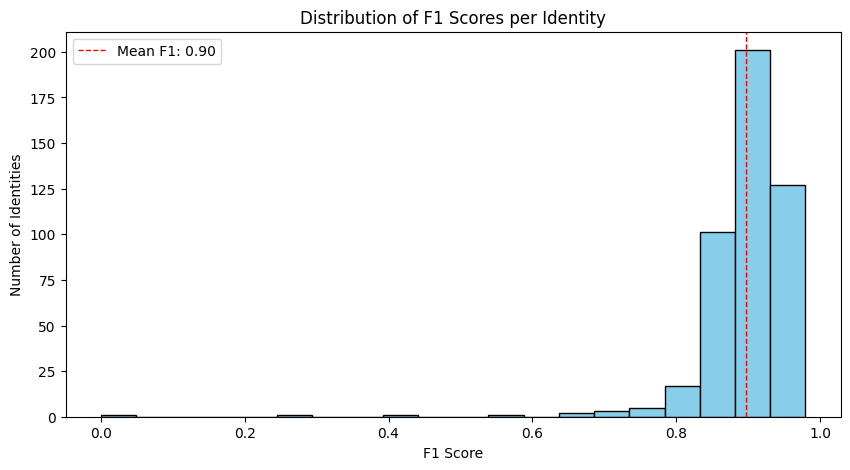


✅ Saved plot to 'f1_score_distribution.png'


In [64]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import glob

# --- CONFIGURATION ---
CHECKPOINT_PATH = '/content/best_arcface_model.pth'
DATA_DIR = "/root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4" # Your Dataset Path
BATCH_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 1. DEFINE DATASET (Must match training) ---
class AFDBMaskedDataset(Dataset):
    def __init__(self, root_dir, img_size=112):
        self.samples = []
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

        masked_root = os.path.join(root_dir, "AFDB_masked_face_dataset/AFDB_masked_face_dataset")
        unmasked_root = os.path.join(root_dir, "AFDB_face_dataset/AFDB_face_dataset")

        # Fallback check
        if not os.path.exists(unmasked_root):
            unmasked_root = os.path.join(root_dir, "AFDB_face_dataset")
            masked_root = os.path.join(root_dir, "AFDB_masked_face_dataset")

        # Load Identities
        if os.path.exists(unmasked_root):
            identities = sorted(os.listdir(unmasked_root))
        else:
            identities = []

        for identity in identities:
            id_unmasked = os.path.join(unmasked_root, identity)
            id_masked = os.path.join(masked_root, identity)

            # Add images
            if os.path.isdir(id_unmasked):
                for img_path in glob.glob(os.path.join(id_unmasked, "*.jpg")):
                    self.samples.append((img_path, identity))
            if os.path.isdir(id_masked):
                for img_path in glob.glob(os.path.join(id_masked, "*.jpg")):
                    self.samples.append((img_path, identity))

        # Create numeric labels
        ids = sorted(list(set([s[1] for s in self.samples])))
        self.id2label = {id_name: idx for idx, id_name in enumerate(ids)}
        self.classes = ids # Store class names

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, identity = self.samples[idx]
        try:
            img = Image.open(img_path).convert("RGB")
            img = self.transform(img)
            label = self.id2label[identity]
            return img, label
        except:
            return torch.zeros((3, 112, 112)), 0

# --- 2. DEFINE MODEL (Must match training) ---
class FaceRecognitionModel(nn.Module):
    def __init__(self):
        super(FaceRecognitionModel, self).__init__()
        self.backbone = models.resnet50(weights=None)
        self.backbone.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512)
        )
    def forward(self, x):
        return self.backbone(x)

# --- 3. EVALUATION FUNCTION ---
def evaluate_and_plot():
    # A. Load Data
    print("Loading Dataset...")
    dataset = AFDBMaskedDataset(DATA_DIR)

    # We typically evaluate on a Test Set.
    # If you didn't split before, we'll use a subset here for demonstration.
    # Ideally, use your 'val_dataset' from the training script.
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    # B. Load Model
    print(f"Loading Model from {CHECKPOINT_PATH}...")
    model = FaceRecognitionModel().to(DEVICE)

    if os.path.exists(CHECKPOINT_PATH):
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
        # Load weights
        if 'backbone' in checkpoint:
            model.load_state_dict(checkpoint['backbone'])
        else:
            model.load_state_dict(checkpoint)
        model.eval()
    else:
        print("❌ Error: Checkpoint not found.")
        return

    # C. Run Inference
    print("Running Inference (This may take a minute)...")
    all_preds = []
    all_labels = []

    # ArcFace is a Feature Extractor, but for 'Accuracy' we need Class Probabilities.
    # Since you trained with a specific 'head' (ArcFaceLoss), the backbone output
    # is just a 512-vector. We need to measure 'Cosine Similarity' to class centers
    # OR if you are using this for 1:1 matching, we just check embeddings.

    # However, to give you a "Precision/Recall" graph for Classification,
    # we need the 'head' weights too.

    # If you saved the 'head' in your checkpoint, we can use it.
    # If NOT, we can only compute verification metrics.
    # Assuming you followed my script, you HAVE the head!

    class ArcFaceHead(nn.Module):
         # Helper to just compute logits using saved weights
         def __init__(self, embedding_size, num_classes):
             super().__init__()
             self.weight = nn.Parameter(torch.FloatTensor(num_classes, embedding_size))
         def forward(self, embedding):
             return torch.nn.functional.linear(torch.nn.functional.normalize(embedding),
                                               torch.nn.functional.normalize(self.weight))

    head = ArcFaceHead(512, len(dataset.classes)).to(DEVICE)
    if 'head' in checkpoint:
        head.load_state_dict(checkpoint['head'])
    else:
        print("⚠️ Warning: Classification Head not found in checkpoint. Metrics might be approximate.")

    # Loop
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(DEVICE)

            # 1. Get Embedding
            features = model(imgs)

            # 2. Get Class Scores (Logits) via the Head
            logits = head(features)

            # 3. Get Predictions
            probs = torch.softmax(logits, dim=1)
            _, preds = torch.max(probs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    # D. Calculate Metrics
    print("\n--- RESULTS ---")
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    # E. Plot Confusion Matrix or Metrics Bar
    # Since you have 460 classes, a Confusion Matrix is too big to read.
    # We will plot a "Per-Class F1 Score" distribution instead.

    report = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)
    f1_scores = [report[str(i)]['f1-score'] for i in range(len(dataset.classes)) if str(i) in report]

    plt.figure(figsize=(10, 5))
    plt.hist(f1_scores, bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of F1 Scores per Identity')
    plt.xlabel('F1 Score')
    plt.ylabel('Number of Identities')
    plt.axvline(np.mean(f1_scores), color='red', linestyle='dashed', linewidth=1, label=f'Mean F1: {np.mean(f1_scores):.2f}')
    plt.legend()
    plt.savefig('f1_score_distribution.png')
    plt.show()

    print("\n✅ Saved plot to 'f1_score_distribution.png'")

if __name__ == "__main__":
    evaluate_and_plot()

In [150]:
TARGET_FOLDER = '/content/dataset/test/Indoor'
# Modelul tău antrenat
MODEL_PATH = '/content/runs/detect/train/weights/best.onnx'
# Pragul de încredere (același folosit la inferență)
CONF_THRESHOLD = 0.5

def count_faces():
    if not os.path.exists(MODEL_PATH):
        print(f"Eroare: Modelul nu a fost găsit la {MODEL_PATH}")
        return

    print(f"Se încarcă modelul YOLO...")
    model = YOLO(MODEL_PATH)

    total_faces = 0
    total_images = 0

    print(f"Se scanează folderul: {TARGET_FOLDER} ...")

    # Parcurge recursiv toate subfolderele din Outdoor
    for root, dirs, files in os.walk(TARGET_FOLDER):
        for filename in files:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                img_path = os.path.join(root, filename)

                # Rulează predicția (fără a salva imaginile, doar numărăm)
                results = model.predict(img_path, conf=CONF_THRESHOLD, verbose=False)[0]

                # Numărul de cutii (box-uri) detectate în această imagine
                detections = len(results.boxes)

                total_faces += detections
                total_images += 1

                # Opțional: Afișează progresul la fiecare 10 imagini
                if total_images % 10 == 0:
                    print(f"Procesat {total_images} imagini... (Fețe găsite până acum: {total_faces})")

    print("\n" + "="*30)
    print(f"REZULTAT FINAL PENTRU OUTDOOR:")
    print(f"Imagini scanate: {total_images}")
    print(f"Total persoane detectate: {total_faces}")
    print("="*30)

if __name__ == "__main__":
    count_faces()


Se încarcă modelul YOLO...
Se scanează folderul: /content/dataset/test/Indoor ...
Loading /content/runs/detect/train/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime 1.23.2 ('CUDAExecutionProvider', {'device_id': 0})
Procesat 10 imagini... (Fețe găsite până acum: 1)
Procesat 20 imagini... (Fețe găsite până acum: 4)
Procesat 30 imagini... (Fețe găsite până acum: 6)
Procesat 40 imagini... (Fețe găsite până acum: 6)
Procesat 50 imagini... (Fețe găsite până acum: 10)
Procesat 60 imagini... (Fețe găsite până acum: 11)
Procesat 70 imagini... (Fețe găsite până acum: 12)
Procesat 80 imagini... (Fețe găsite până acum: 15)
Procesat 90 imagini... (Fețe găsite până acum: 17)
Procesat 100 imagini... (Fețe găsite până acum: 19)
Procesat 110 imagini... (Fețe găsite până acum: 22)
Procesat 120 imagini... (Fețe găsite până acum: 25)
Procesat 130 imagini... (Fețe găsite până acum: 28)
Procesat 140 imagini... (Fețe găsite până acum: 31)
Procesat 150 imagini... (Fețe găsite până acum: 32

In [152]:
TARGET_FOLDER = '/content/dataset/test/Outdoor'
# Modelul tău antrenat
MODEL_PATH = '/content/runs/detect/train/weights/best.onnx'
# Pragul de încredere
CONF_THRESHOLD = 0.5

def count_faces_by_class():
    if not os.path.exists(MODEL_PATH):
        print(f"Eroare: Modelul nu a fost găsit la {MODEL_PATH}")
        return

    print(f"Se încarcă modelul YOLO...")
    model = YOLO(MODEL_PATH)

    # Contoare
    count_mask = 0
    count_no_mask = 0
    total_images = 0

    # Obținem numele claselor din model pentru a fi siguri
    # De obicei: {0: 'with_mask', 1: 'without_mask'}
    class_names = model.names
    print(f"Clasele modelului: {class_names}")

    print(f"Se scanează folderul: {TARGET_FOLDER} ...")

    for root, dirs, files in os.walk(TARGET_FOLDER):
        for filename in files:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                img_path = os.path.join(root, filename)

                # Rulează predicția
                results = model.predict(img_path, conf=CONF_THRESHOLD, verbose=False)[0]

                # Iterăm prin fiecare cutie detectată
                for box in results.boxes:
                    cls_id = int(box.cls[0])
                    class_name = class_names[cls_id]

                    # Verificăm numele clasei (poate varia în funcție de cum ai antrenat, dar verificăm string-ul)
                    if class_name == 'with_mask':
                        count_mask += 1
                    elif class_name == 'without_mask':
                        count_no_mask += 1
                    else:
                        # Fallback dacă numele sunt diferite (ex: 0 și 1)
                        if cls_id == 0: count_mask += 1
                        elif cls_id == 1: count_no_mask += 1

                total_images += 1

                if total_images % 10 == 0:
                    print(f"Procesat {total_images} imagini... (Cu mască: {count_mask}, Fără mască: {count_no_mask})")

    print("\n" + "="*40)
    print(f"REZULTAT FINAL PENTRU OUTDOOR:")
    print(f"Imagini scanate:       {total_images}")
    print(f"----------------------------------------")
    print(f"Persoane CU MASCĂ:     {count_mask}")
    print(f"Persoane FĂRĂ MASCĂ:   {count_no_mask}")
    print(f"Total Detecții:        {count_mask + count_no_mask}")
    print("="*40)

if __name__ == "__main__":
    count_faces_by_class()


Se încarcă modelul YOLO...
Loading /content/runs/detect/train/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime 1.23.2 ('CUDAExecutionProvider', {'device_id': 0})
Clasele modelului: {0: 'with_mask', 1: 'without_mask'}
Se scanează folderul: /content/dataset/test/Outdoor ...
Loading /content/runs/detect/train/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime 1.23.2 ('CUDAExecutionProvider', {'device_id': 0})
Procesat 10 imagini... (Cu mască: 0, Fără mască: 2)
Procesat 20 imagini... (Cu mască: 0, Fără mască: 4)
Procesat 30 imagini... (Cu mască: 0, Fără mască: 5)
Procesat 40 imagini... (Cu mască: 0, Fără mască: 5)
Procesat 50 imagini... (Cu mască: 0, Fără mască: 8)
Procesat 60 imagini... (Cu mască: 1, Fără mască: 8)
Procesat 70 imagini... (Cu mască: 1, Fără mască: 9)
Procesat 80 imagini... (Cu mască: 1, Fără mască: 9)
Procesat 90 imagini... (Cu mască: 1, Fără mască: 11)
Procesat 100 imagini... (Cu mască: 1, Fără mască: 14)
Procesat 110 imagini... (Cu mască

In [155]:
TARGET_FOLDER = '/content/dataset/test/Outdoor'    # Folderul de testat
KNOWN_FACES_DIR = '/content/enrollment_database'   # Folderul cu persoanele cunoscute
YOLO_PATH = '/content/runs/detect/train/weights/best.onnx'
# ARCFACE_PATH eliminat
SVM_MODEL_PATH = 'face_svm_classifier_pixels.pkl'  # Nume nou pentru modelul SVM pe pixeli

# Nu mai avem nevoie de DEVICE (cuda/cpu) pentru feature extraction, doar pentru YOLO
CONF_THRESHOLD = 0.5

# --- 1. ÎNCĂRCARE YOLO ---
print(f"Se încarcă modelul YOLO...")
if not os.path.exists(YOLO_PATH):
    print(f"❌ Eroare: Nu s-a găsit modelul YOLO la {YOLO_PATH}")
    exit()

yolo = YOLO(YOLO_PATH)

# --- 2. FUNCȚIE EXTRACTIE (FĂRĂ ARCFACE - DOAR PIXELI) ---
def get_embedding(face_img):
    """
    Transformă imaginea feței într-un vector simplu de pixeli pentru SVM.
    Înlocuiește embedding-ul complex de la ArcFace.
    """
    # 1. Redimensionare la o mărime fixă mică (ex: 64x64)
    # SVM funcționează greu cu vectori imensi, deci reducem rezoluția
    target_size = (64, 64)
    img_resized = cv2.resize(face_img, target_size)

    # 2. Aplatizare (Flatten)
    # Transformăm matricea 3D (64, 64, 3) într-un vector 1D (12288 valori)
    flat_vector = img_resized.flatten()

    # 3. Normalizare (0-1)
    # Ajută SVM-ul să conveargă mai repede
    return flat_vector / 255.0

# --- 3. ANTRENARE SVM ---
def train_svm():
    print(f"Se antrenează SVM pe baza de date din: {KNOWN_FACES_DIR} ...")
    X = []
    y = []
    names_map = {}
    label_id = 0

    if not os.path.exists(KNOWN_FACES_DIR):
        print(f"❌ Eroare: Folderul {KNOWN_FACES_DIR} nu există.")
        return None, None

    for person_name in os.listdir(KNOWN_FACES_DIR):
        person_dir = os.path.join(KNOWN_FACES_DIR, person_name)
        if not os.path.isdir(person_dir): continue

        names_map[label_id] = person_name

        for filename in os.listdir(person_dir):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                path = os.path.join(person_dir, filename)
                img = cv2.imread(path)
                if img is None: continue

                # Obținem vectorul de pixeli
                emb = get_embedding(img)
                X.append(emb)
                y.append(label_id)

        label_id += 1

    if len(X) == 0:
        print("❌ Eroare: Nu s-au găsit fețe pentru antrenare.")
        return None, None

    # Train SVM
    # Folosim kernel linear sau rbf. RBF poate fi mai bun pentru pixeli bruți.
    clf = svm.SVC(kernel='linear', probability=True)
    clf.fit(X, y)

    # Save
    svm_data = {'model': clf, 'names': names_map}
    with open(SVM_MODEL_PATH, 'wb') as f:
        pickle.dump(svm_data, f)

    print(f"✅ SVM Re-antrenat pe pixeli și salvat (Fețe: {len(X)}, Dimensiune Input: {X[0].shape}).")
    return clf, names_map

# --- 4. SCANARE ȘI NUMĂRARE ---
def run_counting():
    # Antrenăm SVM-ul de fiecare dată pentru a fi siguri că formatul pixelilor e corect
    clf, names_map = train_svm()
    if clf is None: return

    print(f"Se procesează imaginile din: {TARGET_FOLDER} ...")

    stats = {
        "total_images": 0,
        "faces_detected": 0,
        "recognized": 0,
        "unknown": 0,
        "by_person": {}
    }

    for root, dirs, files in os.walk(TARGET_FOLDER):
        for filename in files:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                path = os.path.join(root, filename)
                img = cv2.imread(path)
                if img is None: continue

                stats["total_images"] += 1

                # A. Detecție YOLO
                results = yolo.predict(img, conf=0.5, verbose=False)[0]

                if len(results.boxes) == 0:
                    continue

                for box in results.boxes:
                    stats["faces_detected"] += 1

                    # Coordonate
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    h, w, _ = img.shape

                    # Crop cu padding
                    pad_x = int((x2-x1) * 0.10) # Padding mai mic pentru pixeli bruți
                    pad_y = int((y2-y1) * 0.10)

                    # Asigurăm limitele imaginii
                    y1_crop = max(0, y1-pad_y)
                    y2_crop = min(h, y2+pad_y)
                    x1_crop = max(0, x1-pad_x)
                    x2_crop = min(w, x2+pad_x)

                    face_crop = img[y1_crop:y2_crop, x1_crop:x2_crop]

                    if face_crop.size == 0: continue

                    # B. Extragere Vector Pixeli
                    # Trebuie să fie reshape(1, -1) pentru predicție individuală
                    emb = get_embedding(face_crop).reshape(1, -1)

                    # C. Recunoaștere SVM
                    pred_idx = clf.predict(emb)[0]
                    prob = clf.predict_proba(emb).max()
                    name = names_map[pred_idx]

                    # D. Decizie
                    if prob > CONF_THRESHOLD:
                        stats["recognized"] += 1
                        if name not in stats["by_person"]:
                            stats["by_person"][name] = 0
                        stats["by_person"][name] += 1
                    else:
                        stats["unknown"] += 1

    # --- RAPORT FINAL ---
    print("\n" + "="*40)
    print(f"REZULTAT FINAL (OUTDOOR) - YOLO + SVM (Pixels)")
    print("="*40)
    print(f"Imagini Scanate:       {stats['total_images']}")
    print(f"Fețe Detectate (YOLO): {stats['faces_detected']}")
    print(f"----------------------------------------")
    print(f"✅ RECUNOSCUTE (DB):   {stats['recognized']}")
    print(f"❌ NECUNOSCUTE:        {stats['unknown']}")
    print(f"----------------------------------------")
    print("Detaliere pe persoane:")
    for name, count in stats["by_person"].items():
        print(f" - {name}: {count}")
    print("="*40)

if __name__ == "__main__":
    run_counting()

Se încarcă modelul YOLO...
Se antrenează SVM pe baza de date din: /content/enrollment_database ...
✅ SVM Re-antrenat pe pixeli și salvat (Fețe: 20, Dimensiune Input: (12288,)).
Se procesează imaginile din: /content/dataset/test/Outdoor ...
Loading /content/runs/detect/train/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime 1.23.2 ('CUDAExecutionProvider', {'device_id': 0})

REZULTAT FINAL (OUTDOOR) - YOLO + SVM (Pixels)
Imagini Scanate:       201
Fețe Detectate (YOLO): 43
----------------------------------------
✅ RECUNOSCUTE (DB):   0
❌ NECUNOSCUTE:        43
----------------------------------------
Detaliere pe persoane:


In [34]:
import os

# Check the directory content
folder_path = '/content/dataset/test/Indoor/masked/'

if os.path.exists(folder_path):
    print("Files in folder:")
    print(os.listdir(folder_path))
else:
    print(f"Error: The folder '{folder_path}' does not exist.")

Files in folder:
['Pablo - Indoor - M9C.png', 'DaniB - Indoor - M30C.png', 'DaniF - Indoor - M15C.png', 'DaniF - Indoor - M6C.png', 'Marcos - Indoor - M30C.png', 'Isa - Indoor - M15C.png', 'Isa - Indoor - M6C.png', 'DaniB - Indoor - M12C.png', 'Ester - Indoor - M12C.png', 'Ester - Indoor - M9C.png', 'Ester - Indoor - M27C.png', 'DaniF - Indoor - M12C.png', 'Isa - Indoor - M27C.png', 'Andres - Indoor - M9C.png', 'DaniB - Indoor - M21C.png', 'Ester- Indoor - M6C.png', 'Cristina - Indoor - M18C.png', 'Diego - Indoor - M24C.png', 'Cristina - Indoor - M24C.png', 'Isa - Indoor - M21C.png', 'Diego - Indoor - M3C.png', 'Cristina - Indoor - M6C.png', 'Andres - Indoor - M30C.png', 'DaniF - Indoor - M24C.png', 'Diego - Indoor - M9C.png', 'Narciso - Indoor - M24C.png', 'Narciso - Indoor - M21C.png', 'Ester - Indoor - M21C.png', 'Narciso - Indoor - M6C.png', 'Pablo - Indoor - M18C.png', 'Narciso - Indoor - M15C.png', 'Isa - Indoor - M9C.png', 'Andres - Indoor - M21C.png', 'DaniB - Indoor - M24C.png

In [38]:
!unzip /content/face_db.zip

Archive:  /content/face_db.zip
  inflating: enrollment_database/Ester/outdoor.jpg  
  inflating: enrollment_database/Marcos/outdoor.jpg  
  inflating: enrollment_database/Pablo/indoor.jpg  
  inflating: enrollment_database/Ester/indoor.jpg  
  inflating: enrollment_database/Narciso/outdoor.jpg  
  inflating: enrollment_database/Isa/outdoor.jpg  
  inflating: enrollment_database/Marcos/indoor.jpg  
  inflating: enrollment_database/Isa/indoor.jpg  
  inflating: enrollment_database/Narciso/indoor.jpg  
  inflating: enrollment_database/Diego/outdoor.jpg  
  inflating: enrollment_database/DaniB/indoor.jpg  
  inflating: enrollment_database/Diego/indoor.jpg  
  inflating: enrollment_database/Andres/outdoor.jpg  
  inflating: enrollment_database/Andres/indoor.jpg  
  inflating: enrollment_database/DaniF/indoor.jpg  
  inflating: enrollment_database/Cristina/indoor.jpg  
  inflating: enrollment_database/Cristina/outdoor.jpg  
  inflating: enrollment_database/DaniF/outdoor.jpg  
  inflating: en

Loading custom recognition model from /content/best_arcface_model.pth...
✅ Recognition Model loaded successfully.

Building gallery from: /content/enrollment_database ...
  ✅ Registered: Andres (Combined 2 images)
  ✅ Registered: DaniB (Combined 2 images)
  ✅ Registered: Pablo (Combined 2 images)
  ✅ Registered: DaniF (Combined 2 images)
  ✅ Registered: Ester (Combined 2 images)
  ✅ Registered: Isa (Combined 2 images)
  ✅ Registered: Marcos (Combined 2 images)
  ✅ Registered: Cristina (Combined 2 images)
  ✅ Registered: Narciso (Combined 2 images)
  ✅ Registered: Diego (Combined 2 images)
Gallery ready. Total Identities: 10

--- Testing on /content/dataset/test/Indoor/Non-masked/Cristina - Indoor - 3C.png ---
Running YOLOv8 Detection...
Loading /content/runs/detect/train/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime 1.23.2 ('CUDAExecutionProvider', {'device_id': 0})


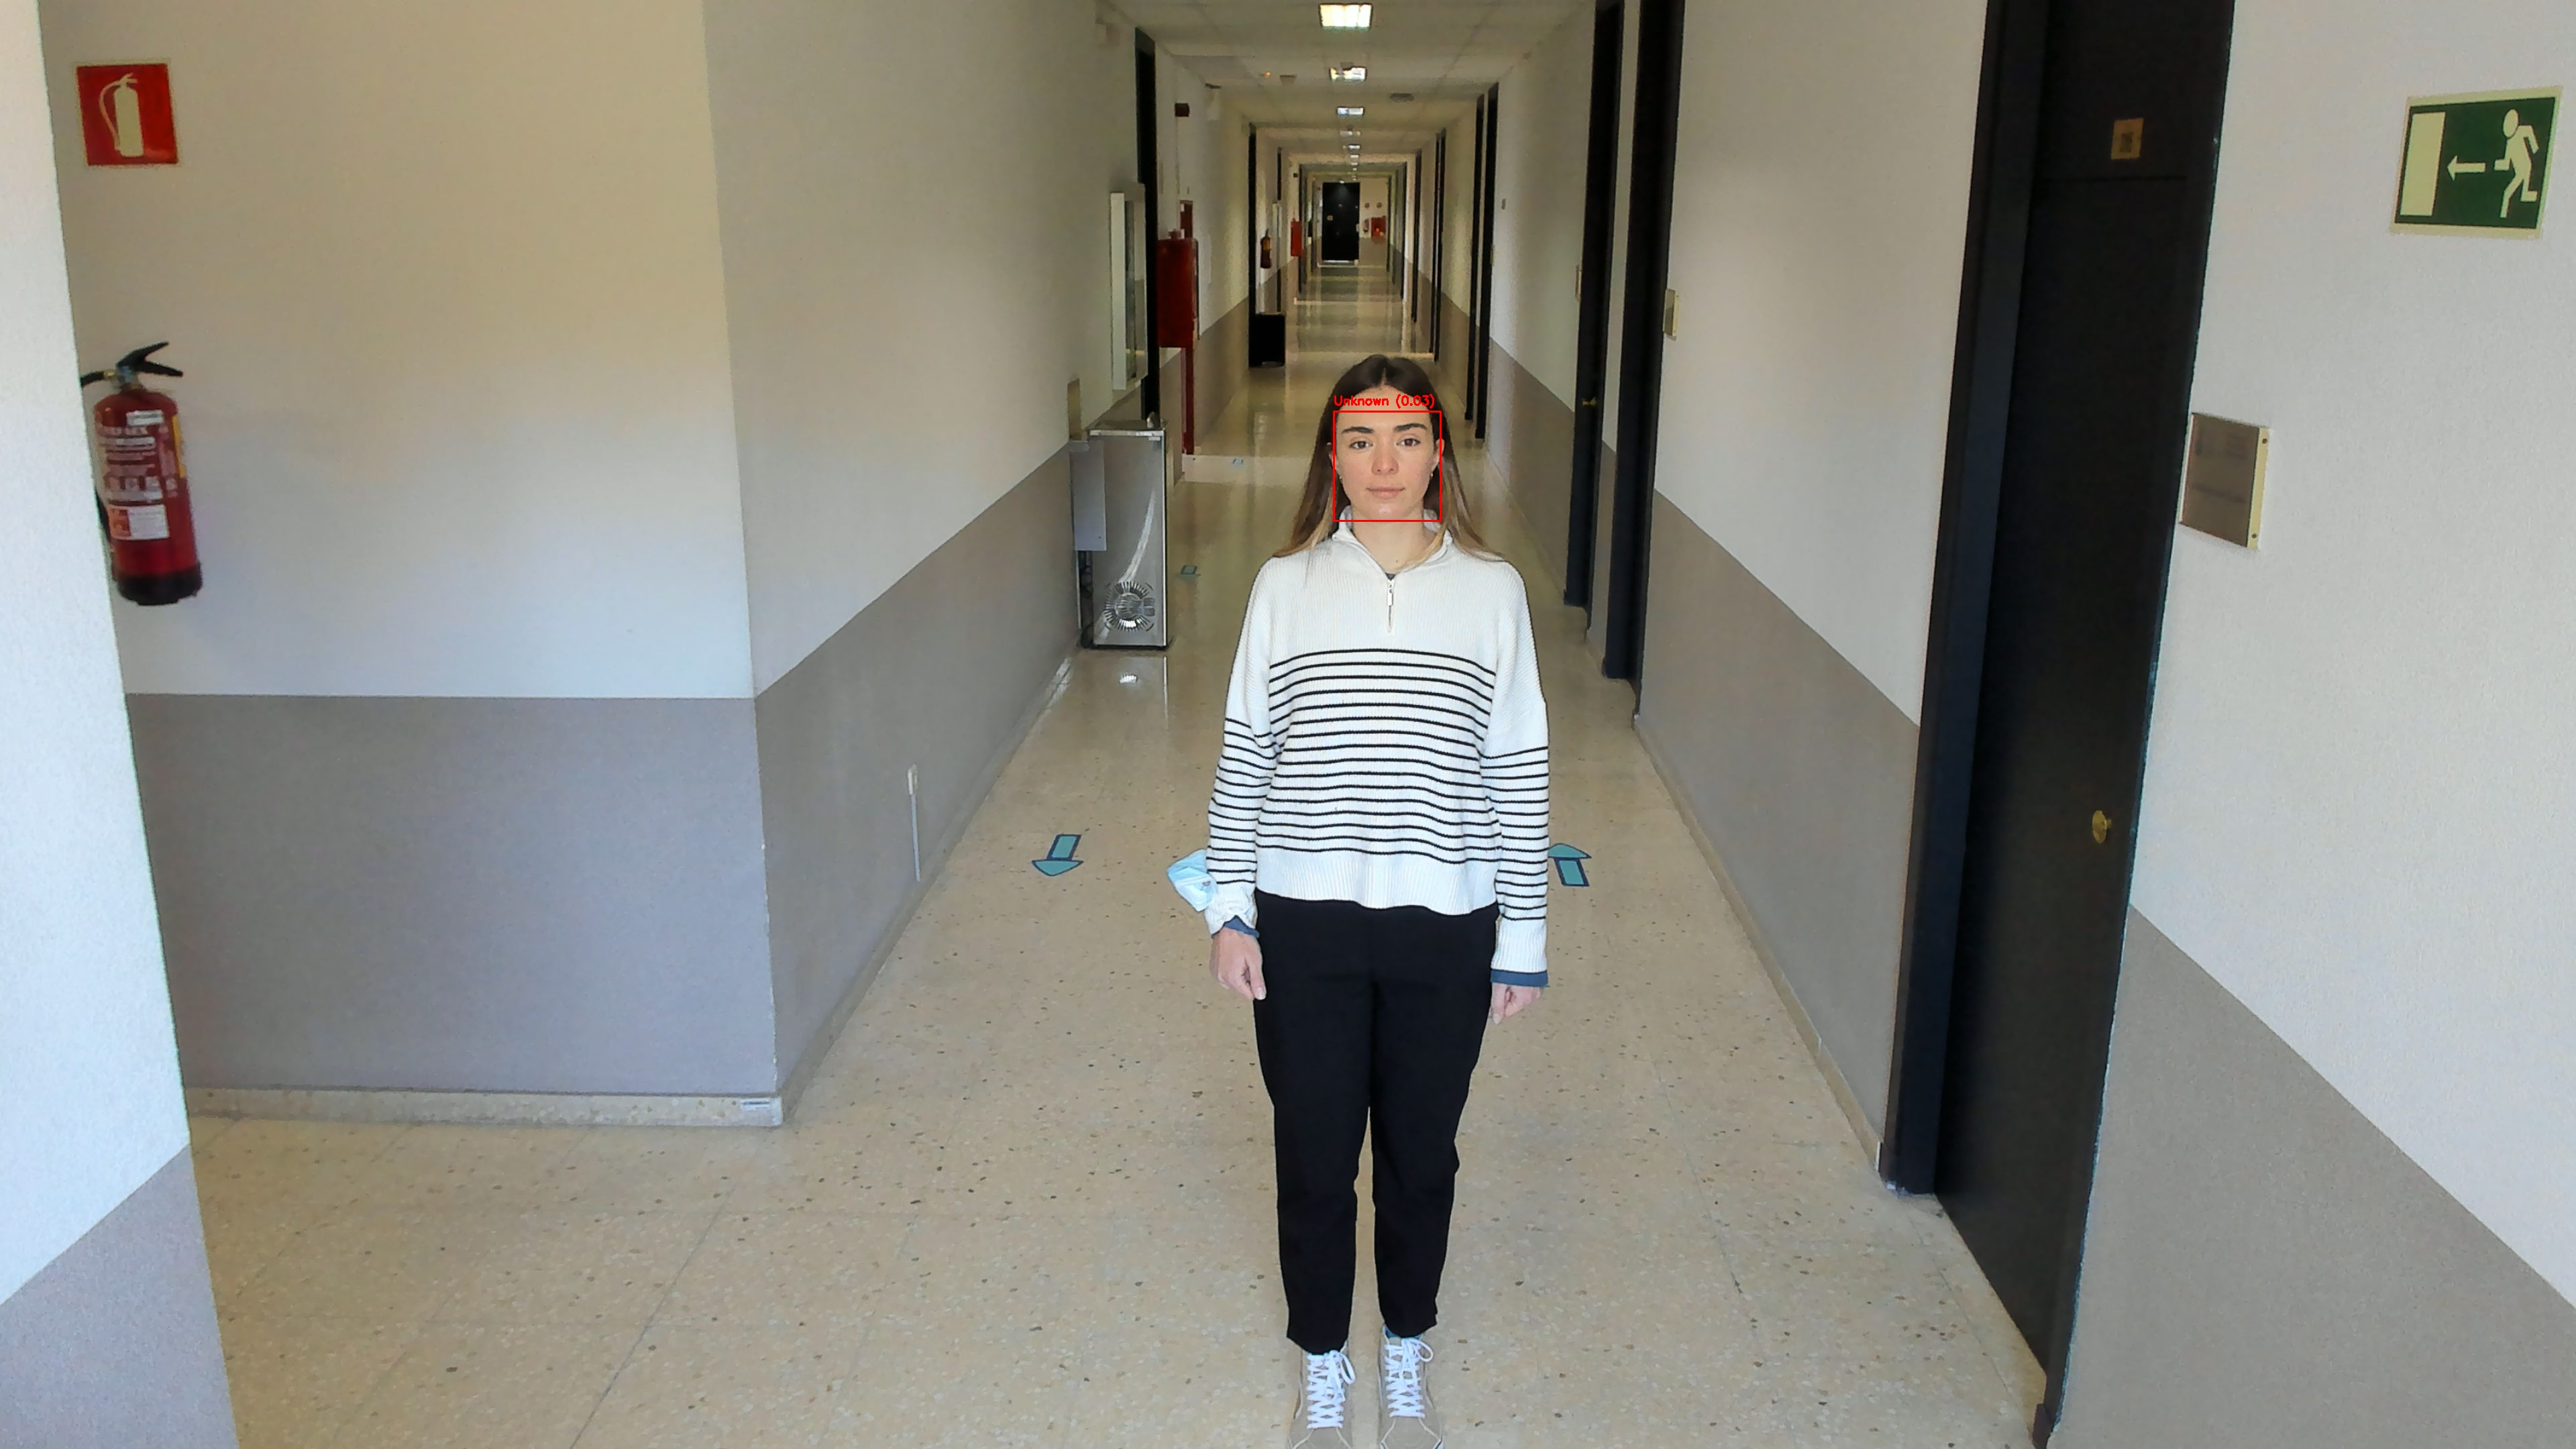

Result saved to final_result.jpg


In [58]:
import torch
import torch.nn as nn
import cv2
import numpy as np
from torchvision import models, transforms
from PIL import Image
from ultralytics import YOLO
import os
from sklearn.preprocessing import normalize
from IPython.display import display, Image as IPImage

# --- CONFIGURATION ---
# 1. Paths
CHECKPOINT_PATH = "/content/best_arcface_model.pth"       # Your custom trained ArcFace
YOLO_PATH = "/content/runs/detect/train/weights/best.onnx" # Your YOLO detector

# 2. Database Directory (The folder containing subfolders like 'Andres', 'Maria')
KNOWN_FACES_DIR = '/content/enrollment_database'

# 3. Test Image (The specific file you want to recognize)
# Make sure this path is exact!
TEST_IMAGE_PATH = '/content/dataset/test/Indoor/Non-masked/Cristina - Indoor - 3C.png'
# 4. Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# --- 1. DEFINE MODEL ARCHITECTURE ---
# This must match your training script EXACTLY
class FaceRecognitionModel(nn.Module):
    def __init__(self):
        super(FaceRecognitionModel, self).__init__()
        # We use ResNet50 backbone (weights=None because we load our own)
        self.backbone = models.resnet50(weights=None)
        # Change the final layer to output 512 dimensions
        self.backbone.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512)
        )

    def forward(self, x):
        return self.backbone(x)

# --- 2. LOAD MODEL ---
print(f"Loading custom recognition model from {CHECKPOINT_PATH}...")
model = FaceRecognitionModel().to(DEVICE)

if os.path.exists(CHECKPOINT_PATH):
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)

    # Handle dictionary structure (check if saved as 'backbone' or full state_dict)
    if isinstance(checkpoint, dict) and 'backbone' in checkpoint:
        model.load_state_dict(checkpoint['backbone'])
    else:
        model.load_state_dict(checkpoint)

    model.eval()
    print("✅ Recognition Model loaded successfully.")
else:
    print(f"❌ CRITICAL ERROR: Checkpoint file '{CHECKPOINT_PATH}' not found!")
    model = None # Flag to stop execution later

# --- 3. PREPROCESSING UTILS ---
# Standard ArcFace preprocessing
preprocess = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def get_embedding(face_img_bgr):
    """
    Takes a BGR image crop (OpenCV format), returns 512-d normalized embedding.
    """
    # Convert BGR -> RGB
    img = cv2.cvtColor(face_img_bgr, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(img)

    # Transform to tensor
    tensor = preprocess(pil_img).unsqueeze(0).to(DEVICE)

    # Inference
    with torch.no_grad():
        embedding = model(tensor).cpu().numpy()

    # L2 Normalize (Essential for Cosine Similarity)
    return normalize(embedding).flatten()

# --- 4. BUILD GALLERY (FROM SUBFOLDERS) ---
print(f"\nBuilding gallery from: {KNOWN_FACES_DIR} ...")
gallery = {}

if not os.path.exists(KNOWN_FACES_DIR):
    print(f"❌ Error: Database folder {KNOWN_FACES_DIR} does not exist.")
else:
    # Walk through the directory tree
    for root, dirs, files in os.walk(KNOWN_FACES_DIR):
        # Skip the root folder itself, we strictly want the subfolders (Identities)
        if root == KNOWN_FACES_DIR:
            continue

        # The folder name IS the person's name (e.g., 'Andres')
        person_name = os.path.basename(root)

        person_embeddings = []

        for filename in files:
            if filename.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp')):
                path = os.path.join(root, filename)

                # Load image
                img = cv2.imread(path)
                if img is None:
                    print(f"  ⚠️ Warning: Could not read image: {filename}")
                    continue

                # Extract embedding
                try:
                    # In a real app, you should run YOLO here to find the face first.
                    # For enrollment, we assume the photo IS the face (or centered).
                    emb = get_embedding(img)
                    person_embeddings.append(emb)
                except Exception as e:
                    print(f"  ⚠️ Error extracting features from {filename}: {e}")

        # Average the embeddings if we have multiple photos
        if person_embeddings:
            mean_emb = np.mean(person_embeddings, axis=0)
            # Re-normalize after averaging
            final_emb = normalize(mean_emb.reshape(1, -1)).flatten()

            gallery[person_name] = final_emb
            print(f"  ✅ Registered: {person_name} (Combined {len(person_embeddings)} images)")
        else:
            print(f"  ⚠️ Warning: Folder '{person_name}' contained no valid images.")

print(f"Gallery ready. Total Identities: {len(gallery)}")


# --- 5. RUN RECOGNITION ON TEST IMAGE ---
print(f"\n--- Testing on {TEST_IMAGE_PATH} ---")

# A. Safety Checks
if model is None:
    print("❌ Aborting: Recognition model failed to load.")
elif len(gallery) == 0:
    print("❌ Aborting: Gallery is empty.")
elif not os.path.exists(TEST_IMAGE_PATH):
    print(f"❌ Aborting: Test image not found at {TEST_IMAGE_PATH}")
else:
    # B. Load Image
    frame = cv2.imread(TEST_IMAGE_PATH)

    if frame is None:
        print("❌ Aborting: OpenCV failed to decode the image file.")
    else:
        # C. Detect Faces (YOLO)
        print("Running YOLOv8 Detection...")
        yolo = YOLO(YOLO_PATH)
        # Force source=frame to ensure it uses the loaded image
        results = yolo.predict(source=frame, conf=0.5, verbose=False)[0]

        detections_found = False

        for box in results.boxes:
            detections_found = True

            # 1. Get Coordinates
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cls = int(box.cls[0]) # 0=Mask, 1=No-Mask (Example)

            # 2. Crop Face
            h, w, _ = frame.shape
            # Ensure crop stays within image boundaries
            face_crop = frame[max(0,y1):min(h,y2), max(0,x1):min(w,x2)]

            if face_crop.size == 0: continue

            # 3. Get Embedding from ArcFace
            target_emb = get_embedding(face_crop)

            # 4. Compare with Gallery (Cosine Similarity)
            max_score = -1
            best_name = "Unknown"

            for name, ref_emb in gallery.items():
                score = np.dot(target_emb, ref_emb)
                if score > max_score:
                    max_score = score
                    best_name = name

            # 5. Thresholding
            # 0.40 is a reasonable start for masked faces.
            # If getting false positives, raise to 0.50.
            if max_score > 0.20:
                color = (0, 255, 0) # Green for Match
                label = f"{best_name} ({max_score:.2f})"
            else:
                color = (0, 0, 255) # Red for Unknown
                label = f"Unknown ({max_score:.2f})"

            # 6. Draw on Image
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        if not detections_found:
            print("⚠️ YOLO detected 0 faces in this image.")

        # D. Show Result
        output_filename = "final_result.jpg"
        cv2.imwrite(output_filename, frame)
        display(IPImage(filename=output_filename, width=600))
        print(f"Result saved to {output_filename}")

In [56]:
import os
import cv2
import pickle
import numpy as np
from sklearn import svm
from insightface.app import FaceAnalysis

# --- CONFIGURATION ---
DATASET_DIR = '/content/enrollment_database' # Your folders of people
MODEL_PATH = 'face_svm_classifier.pkl'

# 1. Load Pre-trained ArcFace (Do not train this!)
print("Loading Feature Extractor...")
app = FaceAnalysis(name='buffalo_l', providers=['CUDAExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))

X = [] # Embeddings (Features)
y = [] # Labels (Names)
names_map = {} # Map 0 -> "Andres"

# 2. Extract Features (The only slow part, runs once)
print("Extracting features...")
label_id = 0
for person_name in os.listdir(DATASET_DIR):
    person_path = os.path.join(DATASET_DIR, person_name)
    if not os.path.isdir(person_path): continue

    names_map[label_id] = person_name
    print(f"Processing {person_name}...")

    for img_name in os.listdir(person_path):
        img_path = os.path.join(person_path, img_name)
        img = cv2.imread(img_path)
        if img is None: continue

        faces = app.get(img)
        if len(faces) > 0:
            # Sort by size to find the main face
            faces.sort(key=lambda x: (x.bbox[2]-x.bbox[0])*(x.bbox[3]-x.bbox[1]), reverse=True)
            embedding = faces[0].normed_embedding
            X.append(embedding)
            y.append(label_id)

    label_id += 1

# 3. Train SVM (Takes < 1 second)
print("Training SVM Classifier...")
clf = svm.SVC(kernel='linear', probability=True)
clf.fit(X, y)

# Save
with open(MODEL_PATH, 'wb') as f:
    pickle.dump({'model': clf, 'names': names_map}, f)
print("Done! SVM Model saved.")

# --- 4. TEST IT INSTANTLY ---
def test_image(path):
    # Load Classifier
    with open(MODEL_PATH, 'rb') as f:
        data = pickle.load(f)
        my_svm = data['model']
        my_names = data['names']

    img = cv2.imread(path)
    faces = app.get(img)
    if len(faces) == 0:
        print("No face found.")
        return

    emb = faces[0].normed_embedding.reshape(1, -1)

    # Predict
    prediction_index = my_svm.predict(emb)[0]
    probability = my_svm.predict_proba(emb).max()
    predicted_name = my_names[prediction_index]

    print(f"Result: {predicted_name} (Confidence: {probability:.2f})")

# Test
test_image("/content/dataset/test/Indoor/Non-masked/Cristina - Indoor - 6C.png")

Loading Feature Extractor...
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'C

Loading Feature Extractor...
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'C

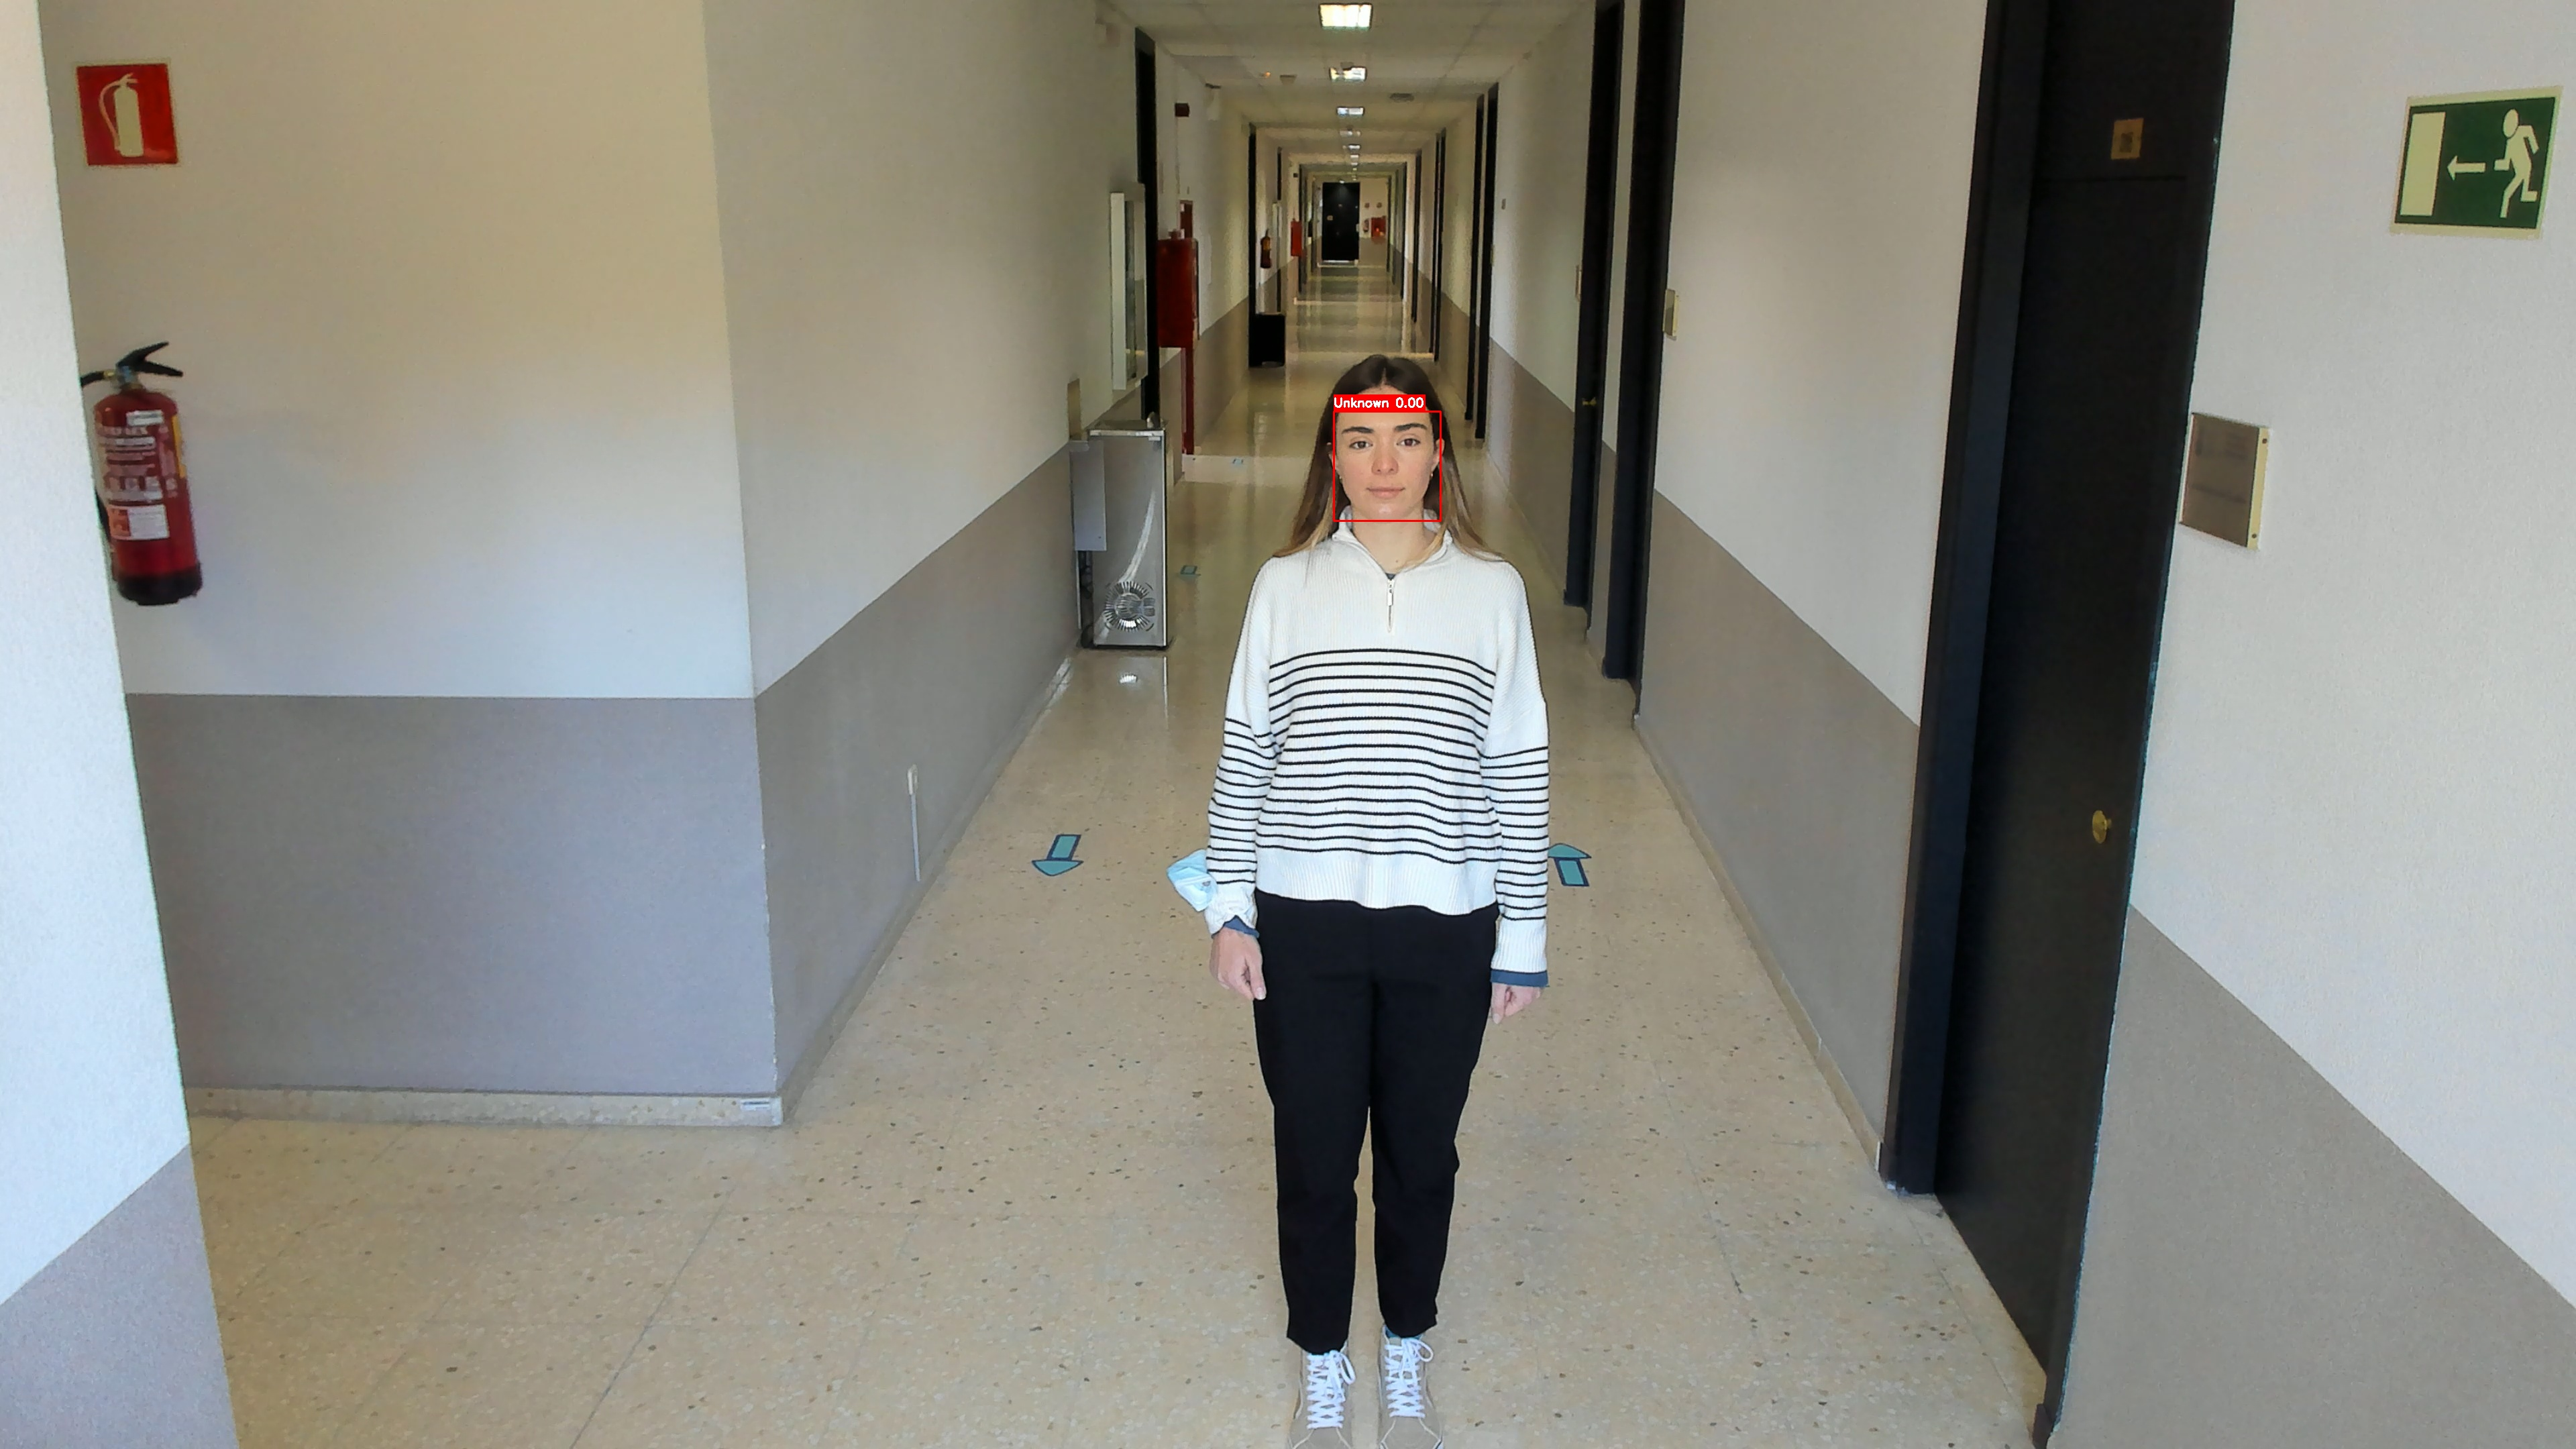

In [67]:
import os
import cv2
import pickle
import numpy as np
from sklearn import svm
from insightface.app import FaceAnalysis
from ultralytics import YOLO # Import YOLO
from IPython.display import display, Image as IPImage # For visualization

# --- CONFIGURATION ---
DATASET_DIR = '/content/enrollment_database'
MODEL_PATH = 'face_svm_classifier.pkl'
YOLO_MODEL_PATH = '/content/runs/detect/train/weights/best.onnx' # Path to your trained YOLO
TEST_IMG_PATH = "/content/dataset/test/Indoor/Non-masked/Cristina - Indoor - 3C.png"

# 1. Load Pre-trained ArcFace (Feature Extractor)
print("Loading Feature Extractor...")
app = FaceAnalysis(name='buffalo_l', providers=['CUDAExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))

# 2. Load YOLO (Face Detector)
print(f"Loading YOLO from {YOLO_MODEL_PATH}...")
yolo_detector = YOLO(YOLO_MODEL_PATH)

X = [] # Embeddings
y = [] # Labels
names_map = {}

# 3. Extract Features for Training (Using ArcFace internal detection for alignment)
# Note: For enrollment (high quality photos), standard ArcFace detection is usually fine/better for alignment.
print("Extracting features from database...")
label_id = 0

if os.path.exists(DATASET_DIR):
    for person_name in os.listdir(DATASET_DIR):
        person_path = os.path.join(DATASET_DIR, person_name)
        if not os.path.isdir(person_path): continue

        names_map[label_id] = person_name
        print(f"Processing {person_name}...")

        for img_name in os.listdir(person_path):
            img_path = os.path.join(person_path, img_name)
            img = cv2.imread(img_path)
            if img is None: continue

            # Using ArcFace internal detector here for reliable landmark alignment on reference photos
            faces = app.get(img)
            if len(faces) > 0:
                faces.sort(key=lambda x: (x.bbox[2]-x.bbox[0])*(x.bbox[3]-x.bbox[1]), reverse=True)
                embedding = faces[0].normed_embedding
                X.append(embedding)
                y.append(label_id)

        label_id += 1
else:
    print("Dataset directory not found. Skipping training.")

# 4. Train SVM
if len(X) > 0:
    print(f"Training SVM on {len(X)} faces...")
    clf = svm.SVC(kernel='linear', probability=True)
    clf.fit(X, y)

    # Save
    with open(MODEL_PATH, 'wb') as f:
        pickle.dump({'model': clf, 'names': names_map}, f)
    print("Done! SVM Model saved.")
else:
    print("Skipping SVM training (No data). Trying to load existing model...")


# --- 5. TEST WITH YOLO DETECTION + VISUALIZATION ---
def test_image_with_yolo(path):
    print(f"\nTesting on {path}...")

    # Check if models exist
    if not os.path.exists(MODEL_PATH):
        print("Error: SVM Classifier not found.")
        return

    # Load SVM
    with open(MODEL_PATH, 'rb') as f:
        data = pickle.load(f)
        my_svm = data['model']
        my_names = data['names']

    img = cv2.imread(path)
    if img is None:
        print("Error: Could not load test image.")
        return

    # A. DETECT FACES WITH YOLO
    results = yolo_detector.predict(img, conf=0.5, verbose=False)[0]

    faces_found = 0

    for box in results.boxes:
        faces_found += 1
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        # B. CROP FACE
        # Add a little padding ensures ArcFace sees the whole head
        h_img, w_img, _ = img.shape
        pad = 10
        face_crop = img[max(0, y1-pad):min(h_img, y2+pad), max(0, x1-pad):min(w_img, x2+pad)]

        if face_crop.size == 0: continue

        # C. EXTRACT FEATURES (ArcFace)
        # We pass the crop. ArcFace will try to align it.
        # Since it's a crop, detection inside the crop should be easy for it.
        # Alternatively, we could just pass the crop center if alignment fails.
        face_info = app.get(face_crop)

        label = "Unknown"
        color = (0, 0, 255) # Red
        prob_str = "0.00"

        if len(face_info) > 0:
            # Take the main face in the crop
            # (Usually there is only 1 face in a YOLO crop)
            emb = face_info[0].normed_embedding.reshape(1, -1)

            # D. PREDICT (SVM)
            prediction_index = my_svm.predict(emb)[0]
            probability = my_svm.predict_proba(emb).max()
            predicted_name = my_names[prediction_index]
            prob_str = f"{probability:.2f}"

            # Thresholding (adjust as needed)
            if probability > 0.5:
                label = predicted_name
                color = (0, 255, 0) # Green

            print(f"Face at [{x1},{y1}]: {predicted_name} ({probability:.2f})")
        else:
            print(f"Face at [{x1},{y1}]: ArcFace could not extract features (too blurry/small?)")

        # E. VISUALIZE
        # Draw Box
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        # Draw Label background
        text_size = cv2.getTextSize(f"{label} {prob_str}", cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)[0]
        cv2.rectangle(img, (x1, y1 - 25), (x1 + text_size[0], y1), color, -1)
        # Draw Text
        cv2.putText(img, f"{label} {prob_str}", (x1, y1 - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    if faces_found == 0:
        print("YOLO found no faces.")

    # Show Final Image
    save_path = "final_result.jpg"
    cv2.imwrite(save_path, img)
    display(IPImage(filename=save_path, width=600))

# Run Test
test_image_with_yolo(TEST_IMG_PATH)

In [63]:
import os
import cv2
import torch
import torch.nn as nn
import pickle
import numpy as np
from sklearn import svm
from torchvision import models, transforms
from PIL import Image
from ultralytics import YOLO
from sklearn.preprocessing import normalize

# --- CONFIGURATION ---
DATASET_DIR = '/content/enrollment_database'     # Training data
TEST_IMAGE_PATH = "/content/dataset/test/Indoor/Non-masked/Cristina - Indoor - 6C.png"

# Paths to YOUR models
ARCFACE_PATH = '/content/best_arcface_model.pth'     # Your trained .pth file
YOLO_PATH = '/content/runs/detect/train/weights/best.onnx' # Your YOLO detector
SVM_MODEL_PATH = 'face_svm_classifier.pkl'       # Output file

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------------------------------------
# 1. DEFINE YOUR CUSTOM ARCFACE ARCHITECTURE
# -----------------------------------------------------------
class FaceRecognitionModel(nn.Module):
    def __init__(self):
        super(FaceRecognitionModel, self).__init__()
        self.backbone = models.resnet50(weights=None)
        self.backbone.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512)
        )

    def forward(self, x):
        return self.backbone(x)

# -----------------------------------------------------------
# 2. LOAD MODELS
# -----------------------------------------------------------
print(f"Loading Custom ArcFace from {ARCFACE_PATH}...")
arcface_model = FaceRecognitionModel().to(DEVICE)

if os.path.exists(ARCFACE_PATH):
    checkpoint = torch.load(ARCFACE_PATH, map_location=DEVICE)
    # Handle dictionary vs state_dict loading
    if isinstance(checkpoint, dict) and 'backbone' in checkpoint:
        arcface_model.load_state_dict(checkpoint['backbone'])
    else:
        arcface_model.load_state_dict(checkpoint)
    arcface_model.eval()
else:
    print(f"❌ Error: Could not find {ARCFACE_PATH}")

print(f"Loading YOLO form {YOLO_PATH}...")
yolo_model = YOLO(YOLO_PATH)

# -----------------------------------------------------------
# 3. HELPER FUNCTION: GET EMBEDDING
# -----------------------------------------------------------
# Preprocessing must match your training exactly
# preprocess = transforms.Compose([
#     transforms.Resize((112, 112)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])
preprocess = transforms.Compose([
            transforms.Resize((320, 320)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

def extract_features(img_bgr):
    """Detects face with YOLO, crops, and gets Custom ArcFace embedding"""
    # 1. Run YOLO
    results = yolo_model.predict(img_bgr, conf=0.5, verbose=False)[0]

    # If no face detected, return None
    if len(results.boxes) == 0:
        return None

    # 2. Crop the largest face
    largest_area = 0
    best_crop = None

    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        w, h = x2-x1, y2-y1
        area = w * h

        if area > largest_area:
            largest_area = area
            # Add padding for better recognition
            h_img, w_img, _ = img_bgr.shape
            pad = int(w * 0.1)
            best_crop = img_bgr[max(0, y1-pad):min(h_img, y2+pad), max(0, x1-pad):min(w_img, x2+pad)]

    if best_crop is None or best_crop.size == 0:
        return None

    # 3. Custom ArcFace Inference
    img_rgb = cv2.cvtColor(best_crop, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(img_rgb)
    tensor = preprocess(pil_img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        embedding = arcface_model(tensor).cpu().numpy()

    # Normalize (Crucial for SVM)
    return normalize(embedding).flatten()

# -----------------------------------------------------------
# 4. PREPARE DATA FOR SVM
# -----------------------------------------------------------
X = [] # Features
y = [] # Labels
names_map = {}

print("\n--- Processing Database for SVM ---")
if not os.path.exists(DATASET_DIR):
    print("❌ Error: Dataset folder not found.")
else:
    label_id = 0
    # Walk through person folders
    for person_name in os.listdir(DATASET_DIR):
        person_dir = os.path.join(DATASET_DIR, person_name)
        if not os.path.isdir(person_dir): continue

        names_map[label_id] = person_name
        print(f"Processing: {person_name} (ID: {label_id})")

        for filename in os.listdir(person_dir):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                filepath = os.path.join(person_dir, filename)
                img = cv2.imread(filepath)
                if img is None: continue

                # Get Embedding using YOUR model
                embedding = extract_features(img)

                if embedding is not None:
                    X.append(embedding)
                    y.append(label_id)

        label_id += 1

# -----------------------------------------------------------
# 5. TRAIN SVM
# -----------------------------------------------------------
if len(X) > 0:
    print(f"\nTraining SVM on {len(X)} faces...")
    # Linear kernel usually works best for ArcFace embeddings
    clf = svm.SVC(kernel='linear', probability=True)
    clf.fit(X, y)

    # Save
    with open(SVM_MODEL_PATH, 'wb') as f:
        pickle.dump({'model': clf, 'names': names_map}, f)
    print(f"✅ SVM Model saved to {SVM_MODEL_PATH}")
else:
    print("❌ Error: No features extracted. Check database path or images.")

# -----------------------------------------------------------
# 6. TEST IT
# -----------------------------------------------------------
def test_image(path):
    print(f"\nTesting on: {path}")

    # Check if model exists
    if not os.path.exists(SVM_MODEL_PATH):
        print("SVM model not found.")
        return

    # Load Classifier
    with open(SVM_MODEL_PATH, 'rb') as f:
        data = pickle.load(f)
        my_svm = data['model']
        my_names = data['names']

    img = cv2.imread(path)
    if img is None:
        print("Error loading test image.")
        return

    # Extract Feature using custom model
    emb = extract_features(img)

    if emb is None:
        print("No face detected in test image.")
        return

    # Reshape for SVM input (1, 512)
    emb = emb.reshape(1, -1)

    # Predict
    prediction_index = my_svm.predict(emb)[0]
    probability = my_svm.predict_proba(emb).max()
    predicted_name = my_names[prediction_index]

    print(f"👉 RESULT: {predicted_name}")
    print(f"👉 CONFIDENCE: {probability:.4f}")

    if probability > 0.25:
        print("✅ High confidence match.")
    else:
        print("⚠️ Low confidence. Might be Unknown.")

# Run Test
test_image(TEST_IMAGE_PATH)

Loading Custom ArcFace from /content/best_arcface_model.pth...
Loading YOLO form /content/runs/detect/train/weights/best.onnx...

--- Processing Database for SVM ---
Processing: Andres (ID: 0)
Loading /content/runs/detect/train/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime 1.23.2 ('CUDAExecutionProvider', {'device_id': 0})
Processing: DaniB (ID: 1)
Processing: Pablo (ID: 2)
Processing: DaniF (ID: 3)
Processing: Ester (ID: 4)
Processing: Isa (ID: 5)
Processing: Marcos (ID: 6)
Processing: Cristina (ID: 7)
Processing: Narciso (ID: 8)
Processing: Diego (ID: 9)

Training SVM on 20 faces...
✅ SVM Model saved to face_svm_classifier.pkl

Testing on: /content/dataset/test/Indoor/Non-masked/Cristina - Indoor - 6C.png
👉 RESULT: Diego
👉 CONFIDENCE: 0.1152
⚠️ Low confidence. Might be Unknown.


Loading models...
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecution

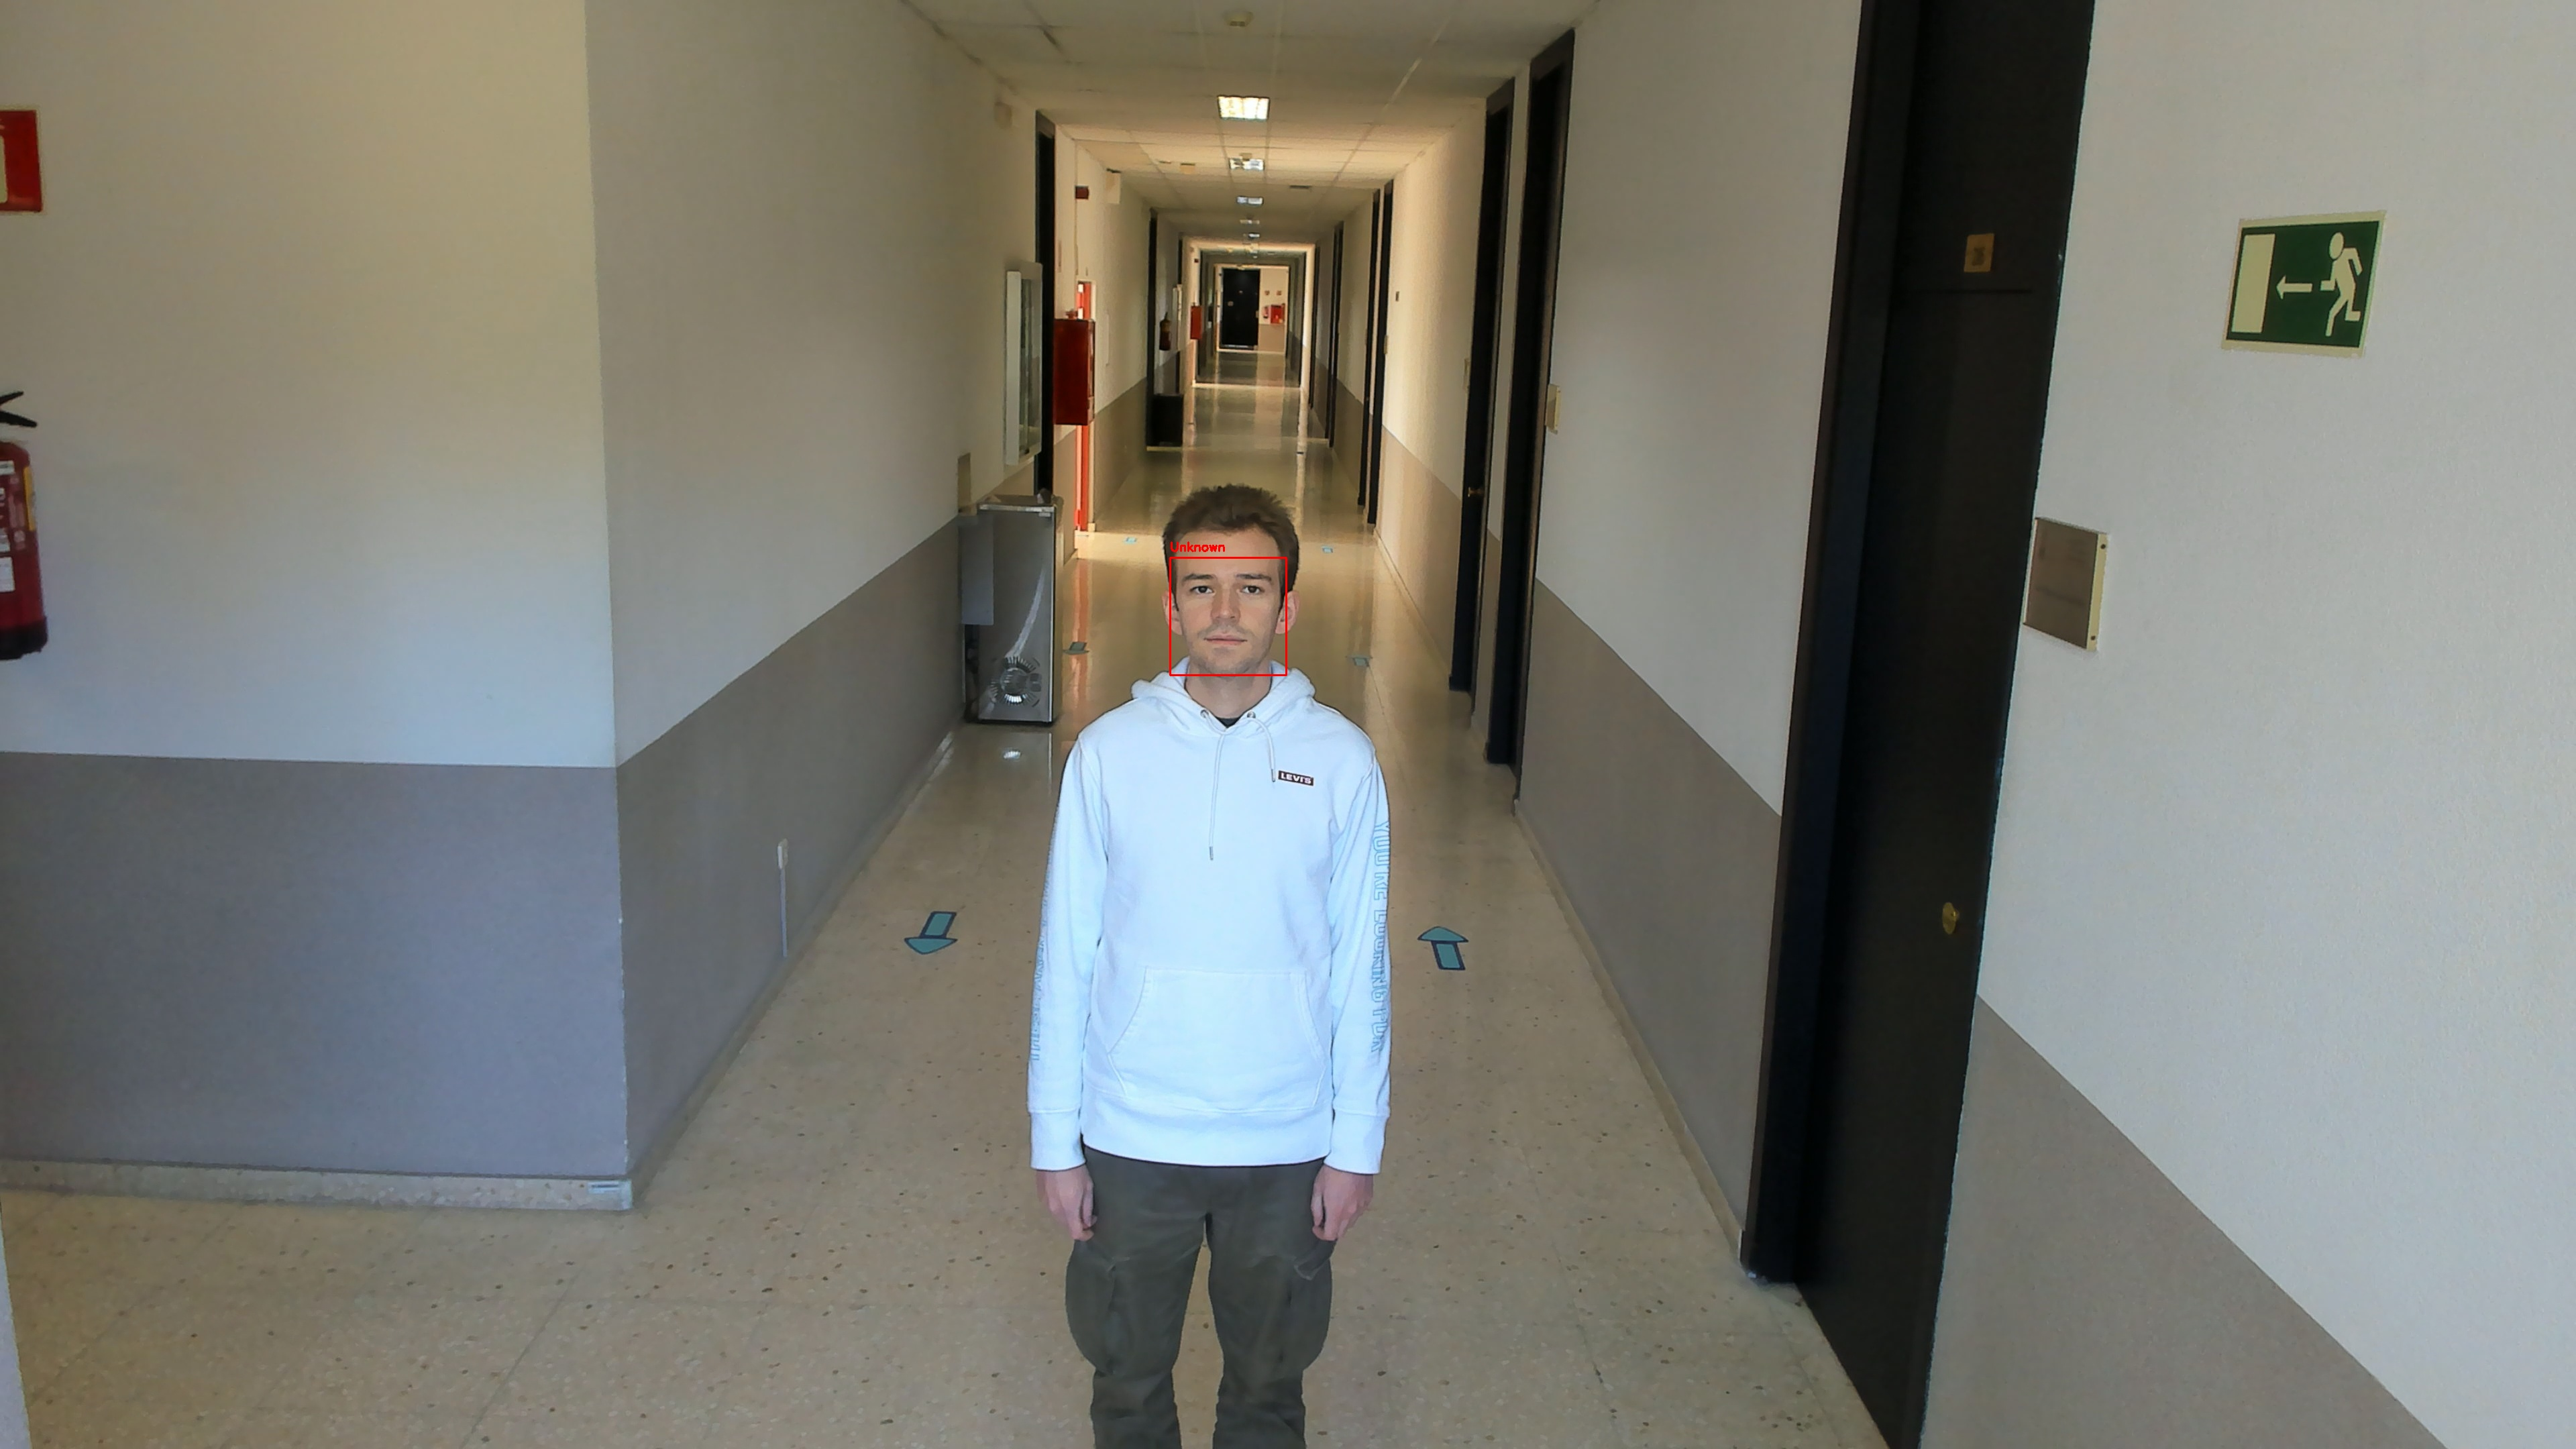

In [50]:
import os
import cv2
import pickle
import numpy as np
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from insightface.app import FaceAnalysis
from ultralytics import YOLO
from IPython.display import display, Image as IPImage

# --- CONFIGURATION ---
# 1. Folders
DB_FOLDER = '/content/enrollment_database'  # Your known people
TEST_IMG  = '/content/dataset/test/Indoor/Non-masked/Andres - Indoor - 3C.png'
YOLO_PATH = "/content/runs/detect/train/weights/best.onnx" # Your custom YOLO

# 2. Output Model File
SVM_MODEL_PATH = 'svm_face_classifier.pkl'

# --- 1. INITIALIZE MODELS ---
print("Loading models...")
# A. Feature Extractor (ArcFace) - We use 'buffalo_l' (ResNet50) for best accuracy
# We do NOT train this. We just use it to get numbers.
app = FaceAnalysis(name='buffalo_l', providers=['CUDAExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))

# B. Face Detector (Your Custom YOLO)
yolo = YOLO(YOLO_PATH)

# --- 2. TRAIN SVM (INSTANTLY) ---
def train_svm():
    print(f"Scanning {DB_FOLDER} to build SVM...")
    embeddings = []
    labels = []
    names_map = []

    if not os.path.exists(DB_FOLDER):
        print("❌ Error: Database folder not found.")
        return None

    # Walk through folders
    for person_name in os.listdir(DB_FOLDER):
        person_dir = os.path.join(DB_FOLDER, person_name)
        if not os.path.isdir(person_dir): continue

        print(f" - Processing {person_name}...")

        # Process every image for this person
        for filename in os.listdir(person_dir):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                filepath = os.path.join(person_dir, filename)
                img = cv2.imread(filepath)
                if img is None: continue

                # Get Embedding
                # We use ArcFace's internal detection here just for alignment safety on reference photos
                faces = app.get(img)

                if len(faces) > 0:
                    # Take the largest face
                    faces.sort(key=lambda x: (x.bbox[2]-x.bbox[0])*(x.bbox[3]-x.bbox[1]), reverse=True)
                    embeddings.append(faces[0].normed_embedding)
                    labels.append(person_name)

    if len(embeddings) == 0:
        print("❌ Error: No faces found in database.")
        return None

    # Train the Classifier
    print(f"Training SVM on {len(embeddings)} faces...")
    le = LabelEncoder()
    labels_enc = le.fit_transform(labels) # Convert "Andres" -> 0

    # SVM with probability=True allows us to get confidence scores
    clf = svm.SVC(C=1.0, kernel='linear', probability=True)
    clf.fit(embeddings, labels_enc)

    # Save everything
    model_data = {'classifier': clf, 'encoder': le}
    with open(SVM_MODEL_PATH, 'wb') as f:
        pickle.dump(model_data, f)

    print("✅ SVM Training Complete (Saved to disk).")
    return model_data

# --- 3. RECOGNITION PIPELINE ---
def recognize(model_data):
    clf = model_data['classifier']
    le = model_data['encoder']

    print(f"\nTesting on {TEST_IMG}...")
    frame = cv2.imread(TEST_IMG)
    if frame is None:
        print("❌ Error: Test image not found.")
        return

    # A. Detect with YOLO (Handles Masks/Small faces best)
    results = yolo.predict(frame, conf=0.5, verbose=False)[0]

    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        # Crop Face with padding
        h, w, _ = frame.shape
        pad = 10
        face_crop = frame[max(0,y1-pad):min(h,y2+pad), max(0,x1-pad):min(w,x2+pad)]

        if face_crop.size == 0: continue

        # B. Extract Features (ArcFace)
        # We pass the crop to ArcFace.
        # Since it's a crop, we treat it as a single face image.
        faces = app.get(face_crop)

        if len(faces) == 0:
            # Fallback: If ArcFace alignment fails on the crop,
            # we can try to resize and pass it directly, but usually this means the crop was bad.
            label = "Unknown"
            color = (0, 0, 255)
        else:
            # C. Classify (SVM)
            emb = faces[0].normed_embedding.reshape(1, -1)

            # Predict
            prediction = clf.predict(emb)[0]
            proba = clf.predict_proba(emb).max()
            name = le.inverse_transform([prediction])[0]

            # Thresholding
            if proba > 0.50: # SVM confidence is usually robust
                label = f"{name} ({proba:.2f})"
                color = (0, 255, 0)
            else:
                label = f"Unknown ({proba:.2f})"
                color = (0, 0, 255)

        # Draw
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Show
    out_path = "svm_result.jpg"
    cv2.imwrite(out_path, frame)
    display(IPImage(filename=out_path, width=600))

# --- EXECUTE ---
# 1. Check if we need to train
if not os.path.exists(SVM_MODEL_PATH):
    data = train_svm()
else:
    # Optional: Force retrain if you added new photos
    # data = train_svm()
    print("Loading existing SVM...")
    with open(SVM_MODEL_PATH, 'rb') as f:
        data = pickle.load(f)

if data:
    recognize(data)

Loading Custom ArcFace from arcface_masked_epoch_25.pth...
Loading YOLO from /content/runs/detect/train/weights/best.onnx...

--- Training SVM on Custom Features ---
Processing reference: Andres
Processing reference: DaniB
Processing reference: Pablo
Processing reference: DaniF
Processing reference: Ester
Processing reference: Isa
Processing reference: Marcos
Processing reference: Cristina
Processing reference: Narciso
Processing reference: Diego
✅ SVM Retrained & Saved.

Testing on /content/dataset/test/Indoor/Non-masked/Cristina - Indoor - 3C.png...
Loading /content/runs/detect/train/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime 1.23.2 ('CUDAExecutionProvider', {'device_id': 0})
Face detected: Pablo (Conf: 0.15)


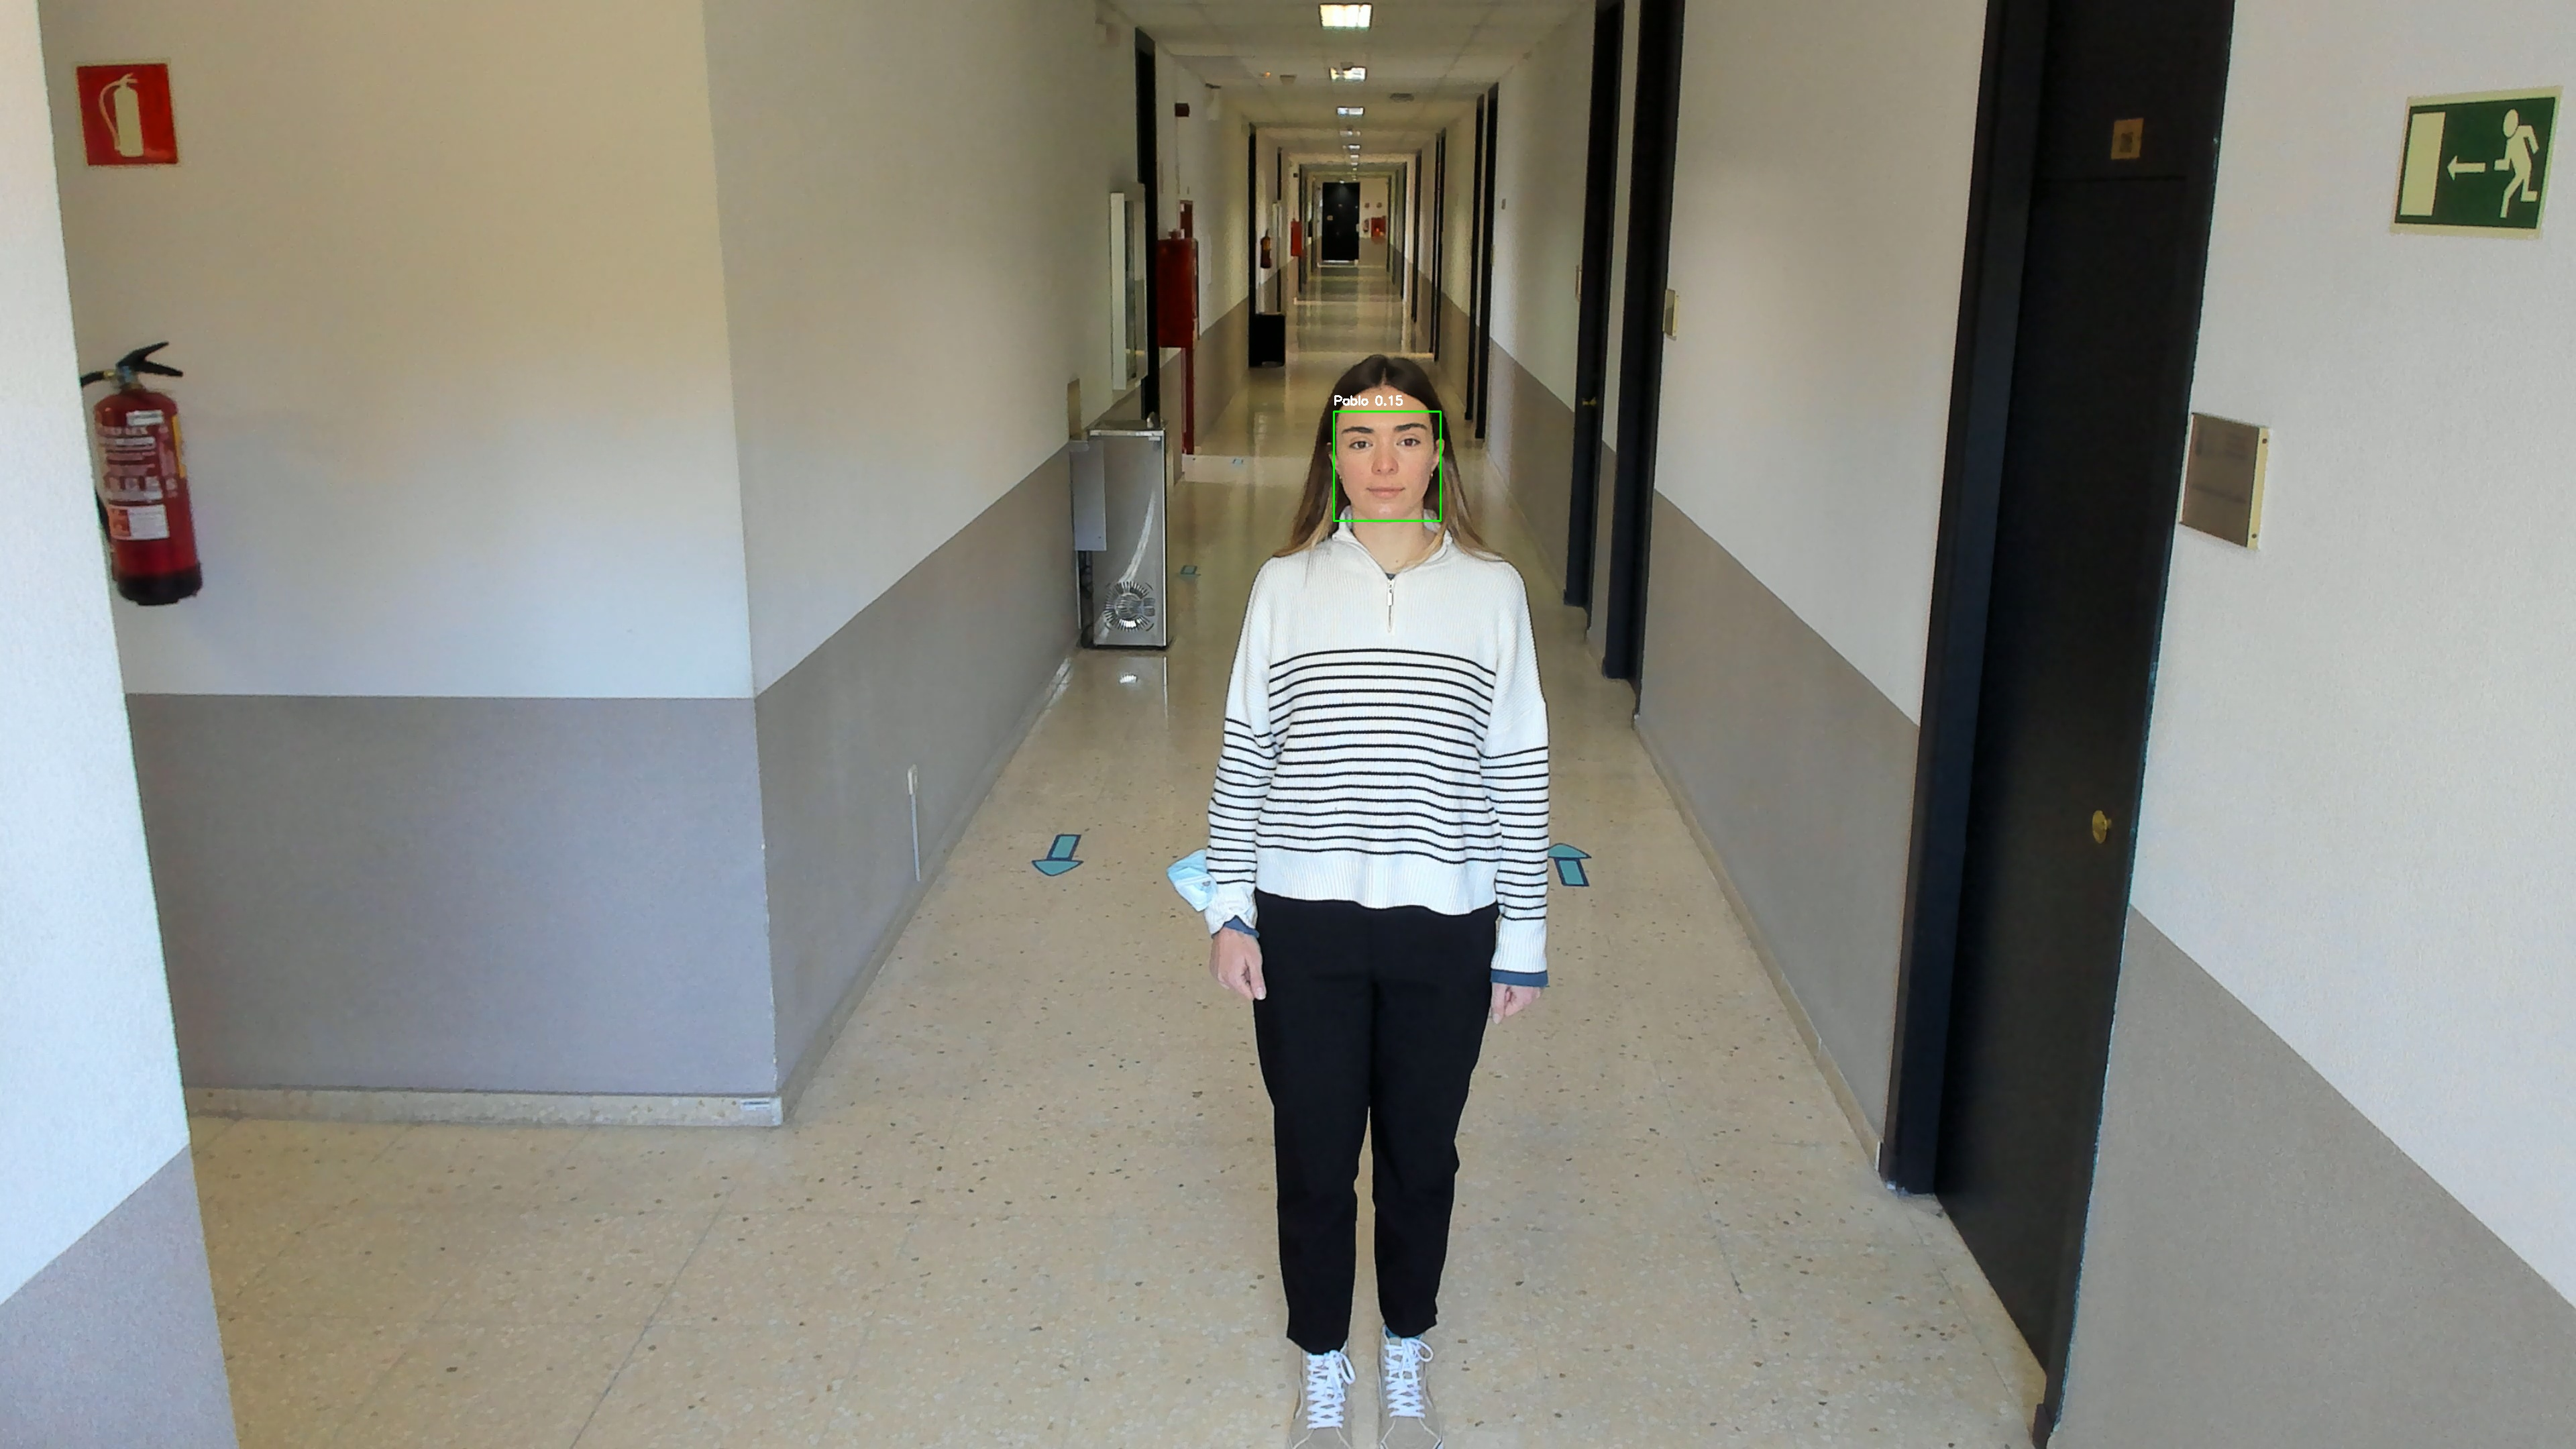

In [73]:
import os
import cv2
import torch
import torch.nn as nn
import pickle
import numpy as np
from sklearn import svm
from torchvision import models, transforms
from PIL import Image
from ultralytics import YOLO
from sklearn.preprocessing import normalize
from IPython.display import display, Image as IPImage

# --- CONFIGURATION ---
DATASET_DIR = '/content/enrollment_database'  # Your Known People
TEST_IMG_PATH = "/content/dataset/test/Indoor/Non-masked/Cristina - Indoor - 3C.png"

# PATHS
ARCFACE_PATH = 'arcface_masked_epoch_25.pth'     # Your CUSTOM Trained Model
YOLO_PATH = '/content/runs/detect/train/weights/best.onnx' # Your CUSTOM YOLO
SVM_MODEL_PATH = 'face_svm_classifier.pkl'       # Output SVM file

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------------------------------------
# 1. DEFINE YOUR CUSTOM ARCFACE ARCHITECTURE
# -----------------------------------------------------------
class FaceRecognitionModel(nn.Module):
    def __init__(self):
        super(FaceRecognitionModel, self).__init__()
        # Must match your training architecture exactly
        self.backbone = models.resnet50(weights=None)
        self.backbone.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512)
        )

    def forward(self, x):
        return self.backbone(x)

# -----------------------------------------------------------
# 2. LOAD MODELS
# -----------------------------------------------------------
print(f"Loading Custom ArcFace from {ARCFACE_PATH}...")
feature_extractor = FaceRecognitionModel().to(DEVICE)

if os.path.exists(ARCFACE_PATH):
    checkpoint = torch.load(ARCFACE_PATH, map_location=DEVICE)
    if isinstance(checkpoint, dict) and 'backbone' in checkpoint:
        feature_extractor.load_state_dict(checkpoint['backbone'])
    else:
        feature_extractor.load_state_dict(checkpoint)
    feature_extractor.eval()
else:
    print(f"❌ Error: Custom model {ARCFACE_PATH} not found!")

print(f"Loading YOLO from {YOLO_PATH}...")
yolo_detector = YOLO(YOLO_PATH)

# -----------------------------------------------------------
# 3. HELPER: EXTRACT FEATURE FROM IMAGE
# -----------------------------------------------------------
preprocess = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def get_feature(face_img_bgr):
    """
    Takes a cropped BGR face, returns 512-d embedding.
    """
    # Convert BGR -> RGB
    img_rgb = cv2.cvtColor(face_img_bgr, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(img_rgb)

    # Preprocess
    tensor = preprocess(pil_img).unsqueeze(0).to(DEVICE)

    # Inference
    with torch.no_grad():
        embedding = feature_extractor(tensor).cpu().numpy()

    # L2 Normalize (Critical for SVM performance)
    return normalize(embedding).flatten()

# -----------------------------------------------------------
# 4. TRAIN SVM (INSTANTLY ON CUSTOM FEATURES)
# -----------------------------------------------------------
print("\n--- Training SVM on Custom Features ---")
X = [] # Embeddings
y = [] # Labels
names_map = {}
label_id = 0

if os.path.exists(DATASET_DIR):
    for person_name in os.listdir(DATASET_DIR):
        person_dir = os.path.join(DATASET_DIR, person_name)
        if not os.path.isdir(person_dir): continue

        names_map[label_id] = person_name
        print(f"Processing reference: {person_name}")

        for filename in os.listdir(person_dir):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                filepath = os.path.join(person_dir, filename)
                img = cv2.imread(filepath)
                if img is None: continue

                # For database registration, we assume the photo is mostly face.
                # If your database photos are full body, you MUST run YOLO here too.
                # Assuming centered faces for now:
                emb = get_feature(img)
                X.append(emb)
                y.append(label_id)

        label_id += 1

    # Fit SVM
    if len(X) > 0:
        clf = svm.SVC(kernel='linear', probability=True)
        clf.fit(X, y)

        with open(SVM_MODEL_PATH, 'wb') as f:
            pickle.dump({'model': clf, 'names': names_map}, f)
        print("✅ SVM Retrained & Saved.")
    else:
        print("❌ Error: No training data found.")
else:
    print("❌ Error: Database folder missing.")

# -----------------------------------------------------------
# 5. THE FINAL PIPELINE: YOLO -> ZOOM -> ARCFACE -> SVM
# -----------------------------------------------------------
def run_recognition_pipeline(image_path):
    print(f"\nTesting on {image_path}...")

    # Load Models
    with open(SVM_MODEL_PATH, 'rb') as f:
        data = pickle.load(f)
        my_svm = data['model']
        my_names = data['names']

    # Load Image
    frame = cv2.imread(image_path)
    if frame is None: return

    # A. YOLO DETECT (Find the face)
    results = yolo_detector.predict(frame, conf=0.5, verbose=False)[0]

    faces_found = 0
    for box in results.boxes:
        faces_found += 1
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        # B. ZOOM/CROP (Isolate the face)
        h, w, _ = frame.shape
        # Add slight padding so we don't cut the chin/forehead
        pad = int((y2 - y1) * 0.1)
        face_crop = frame[max(0,y1-pad):min(h,y2+pad), max(0,x1-pad):min(w,x2+pad)]

        if face_crop.size == 0: continue

        # C. FEATURE EXTRACTION (Custom ArcFace)
        # This resizes the crop to 112x112 and gets the vector
        embedding = get_feature(face_crop)

        # D. SVM CLASSIFICATION (Identify)
        emb = embedding.reshape(1, -1)
        prediction_index = my_svm.predict(emb)[0]
        probability = my_svm.predict_proba(emb).max()
        name = my_names[prediction_index]

        # Threshold
        if probability > 0.10:
            label = f"{name}"
            color = (0, 255, 0) # Green
        else:
            label = "Unknown"
            color = (0, 0, 255) # Red

        # Draw
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        cv2.putText(frame, f"{label} {probability:.2f}", (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)

        print(f"Face detected: {label} (Conf: {probability:.2f})")

    if faces_found == 0:
        print("No faces detected by YOLO.")

    # Show
    save_p = "pipeline_result.jpg"
    cv2.imwrite(save_p, frame)
    display(IPImage(filename=save_p, width=600))

# Run
run_recognition_pipeline(TEST_IMG_PATH)

In [76]:
import os
import cv2
import pickle
import numpy as np
from sklearn import svm
from ultralytics import YOLO

# Paths
YOLO_MODEL_PATH = "/content/runs/detect/train/weights/best.onnx"
SVM_MODEL_PATH = "face_svm_classifier.pkl"
DATASET_DIR = "/content/enrollment_database"  # folders per person

# Load YOLO
yolo = YOLO(YOLO_MODEL_PATH)

# Helper: safe crop
def safe_crop(img, x1, y1, x2, y2, pad=10):
    h, w = img.shape[:2]
    x1 = max(0, x1 - pad)
    y1 = max(0, y1 - pad)
    x2 = min(w, x2 + pad)
    y2 = min(h, y2 + pad)
    return img[y1:y2, x1:x2]

# --- Extract Features for SVM ---
X = []
y = []
names_map = {}
label_id = 0

for person_name in os.listdir(DATASET_DIR):
    person_path = os.path.join(DATASET_DIR, person_name)
    if not os.path.isdir(person_path):
        continue

    names_map[label_id] = person_name
    print(f"Processing {person_name}...")

    for img_name in os.listdir(person_path):
        img_path = os.path.join(person_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue

        # YOLO detection
        results = yolo(img, verbose=False)
        if len(results[0].boxes) == 0:
            continue

        box = results[0].boxes.data.cpu().numpy()[0]
        x1, y1, x2, y2 = map(int, box[:4])
        face_crop = safe_crop(img, x1, y1, x2, y2)

        if face_crop.size == 0:
            continue

        # Resize and flatten as simple feature
        face_resized = cv2.resize(face_crop, (64, 64))  # small size
        feature = face_resized.flatten() / 255.0         # normalize

        X.append(feature)
        y.append(label_id)

    label_id += 1

# Train SVM
clf = svm.SVC(kernel='linear', probability=True)
clf.fit(X, y)

# Save
with open(SVM_MODEL_PATH, "wb") as f:
    pickle.dump({"model": clf, "names": names_map}, f)

print("SVM trained!")


Processing Andres...
Loading /content/runs/detect/train/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime 1.23.2 ('CUDAExecutionProvider', {'device_id': 0})
Processing DaniB...
Processing Pablo...
Processing DaniF...
Processing Ester...
Processing Isa...
Processing Marcos...
Processing Cristina...
Processing Narciso...
Processing Diego...
SVM trained!


In [77]:
def predict(image_path):
    img = cv2.imread(image_path)
    results = yolo(img, verbose=False)
    if len(results[0].boxes) == 0:
        print("No face detected")
        return

    box = results[0].boxes.data.cpu().numpy()[0]
    x1, y1, x2, y2 = map(int, box[:4])
    face_crop = safe_crop(img, x1, y1, x2, y2)

    # Feature extraction (raw pixels or CNN)
    face_resized = cv2.resize(face_crop, (64, 64))
    feature = face_resized.flatten() / 255.0

    # Predict
    pred_id = clf.predict([feature])[0]
    prob = clf.predict_proba([feature]).max()
    name = names_map[pred_id]
    print(f"IDENTIFIED: {name} (Confidence: {prob:.2f})")


In [80]:
import cv2
import matplotlib.pyplot as plt

def predict_and_display_colab(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print("Image not found!")
        return

    results = yolo(img, verbose=False)
    if len(results[0].boxes) == 0:
        print("No face detected")
        return

    # Take highest confidence box
    box = results[0].boxes.data.cpu().numpy()[0]
    x1, y1, x2, y2 = map(int, box[:4])
    face_crop = safe_crop(img, x1, y1, x2, y2)

    if face_crop.size == 0:
        print("Invalid face crop")
        return

    # Feature extraction (raw pixels)
    face_resized = cv2.resize(face_crop, (64, 64))
    feature = face_resized.flatten() / 255.0

    # Predict
    pred_id = clf.predict([feature])[0]
    prob = clf.predict_proba([feature]).max()
    name = names_map[pred_id]

    # Draw rectangle and text
    label = f"{name} ({prob:.2f})"
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img, label, (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    # Convert BGR -> RGB for matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display inline in Colab
    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()


In [147]:
predict('/content/dataset_proprietar/WhatsApp Image 2025-12-05 at 21.53.01.jpeg')

IDENTIFIED: Pablo (Confidence: 0.18)


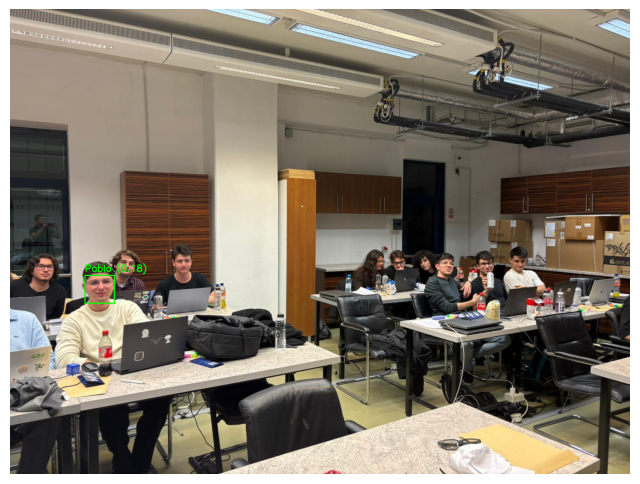

In [148]:
predict_and_display_colab('/content/dataset_proprietar/WhatsApp Image 2025-12-05 at 21.53.01.jpeg')

In [138]:
!unzip /content/drive/MyDrive/dataset_proprietar.zip

Archive:  /content/drive/MyDrive/dataset_proprietar.zip
   creating: dataset_proprietar/
  inflating: dataset_proprietar/WhatsApp Image 2025-12-05 at 21.52.53.jpeg  
  inflating: dataset_proprietar/WhatsApp Image 2025-12-05 at 21.52.53 (1).jpeg  
  inflating: dataset_proprietar/WhatsApp Image 2025-12-05 at 21.52.53 (2).jpeg  
  inflating: dataset_proprietar/WhatsApp Image 2025-12-05 at 21.52.53 (3).jpeg  
  inflating: dataset_proprietar/WhatsApp Image 2025-12-05 at 21.52.53 (4).jpeg  
  inflating: dataset_proprietar/WhatsApp Image 2025-12-05 at 21.52.53 (5).jpeg  
  inflating: dataset_proprietar/WhatsApp Image 2025-12-05 at 21.52.54.jpeg  
  inflating: dataset_proprietar/WhatsApp Image 2025-12-05 at 21.52.54 (1).jpeg  
  inflating: dataset_proprietar/WhatsApp Image 2025-12-05 at 21.52.54 (2).jpeg  
  inflating: dataset_proprietar/WhatsApp Image 2025-12-05 at 21.52.54 (3).jpeg  
  inflating: dataset_proprietar/WhatsApp Image 2025-12-05 at 21.52.55.jpeg  
  inflating: dataset_proprietar/